In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import time
from scipy.optimize import minimize, approx_fprime

In [2]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 1000
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True 
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [3]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.998e10 # cms-1
n_den = 2.3e14
km2cm = 1e5
msun = 1.989e33
gamma = 2.5
K = 3e-3

path = "eos_data/nl3cr.csv"

def lamba_metric(M, R):
    return -0.5*np.log((1-2*G*M/(c**2*R)))

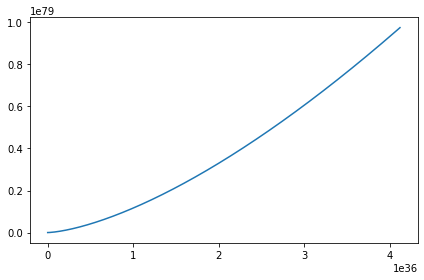

In [4]:
### EOS DATA ###

def df_to_ep(df):
    e_den = df.energy_densityc2
    e_den_normed = e_den#/n_den
    p = df.pressurec2
    e_den_normed = e_den_normed*((2.998e10)**2)
    pressure = p*((2.998e10)**2)
    return e_den_normed.to_numpy(), pressure.to_numpy()

def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value=(0, 0), 
                          kind = "cubic", bounds_error=False)
    return f_e_smooth

def get_pe(p, e):
    f_e_smooth = interp1d(e, p, fill_value=(0, 0), 
                          kind = "cubic", bounds_error=False)
    return f_e_smooth

def dPde_helper(p, e):
    return np.gradient(get_pe(p, e)(e), e)

def dPde(p, e):
    return interp1d(e, dPde_helper(p, e), fill_value=(0, 0), bounds_error=True)

df = pd.read_csv(path)
e, p = df_to_ep(df)
p_min = min(p)
EOS = get_ep(p, e)
dpde = dPde(p, e)

def dPdrho(e, dpde = dpde):
    return c**2 * dpde(e)

### POLYTROPE ###
def P(e, gamma = 2.5, K = K):
    ret = K*(c**(-2*gamma))*(e**gamma)
    return K*(c**(-2*gamma))*(e**gamma)

def dPde(e, gamma = 2.5, K = K):
    return K*(c**(-2*gamma))*(e**(gamma-1)) * gamma 

def dPdrho(e, gamma = gamma, K = K):
    ret = K*(c**(gamma))*(e**(gamma-1)) * gamma 
    return ret

plt.figure()
plt.plot(e, dPdrho(e))
plt.show()

In [5]:
# Working in manual cgs units here. 

# DIMENSIONS CHECKED
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))

# DIMENSIONS CHECKED
def _dPhidr(r, P, M):
    factor1 = G/(c**2) 
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return factor1*num/dem

# DIMENSIONS CHECKED
def _dPdr(r, P, M, e):
    factor2 = -1 # factor goes in dphi/dr
    term1 = (e+P) 
    dphidr = _dPhidr(r, P, M)
    return factor2 * term1 * dphidr

# DIMENSIONS CHECKED
def _dWdr(r, V, W, phi, dphidr, drhodp, omega, lamda, l):
    term1 = (omega**2) * (r**2) * np.exp(lamda - 2*phi)*V
    term2 = dphidr * W * (c**2)
    brackets = term1 + term2
    print(drhodp, brackets, drhodp * brackets)
    ret = (drhodp * brackets) - l*(l+1)*np.exp(lamda)*V
    return ret

# DIMENSIONS CHECKED
def _dVdr(r, V, W, dphidr, lamda):
    return 2*dphidr*V - np.exp(lamda)*(W/(r**2))

def coupledTOV(r, VEC, init_params):
    P, M, phi, W, V = VEC
    EOS, l, omega = init_params
    lamda = lamba_metric(M, r)
    
    if P <= p_min: 
        return None
    
    e = EOS(P)

    dpdrho = dPdrho(e)
    c_ad2 = dpdrho
    drhodp = 1/c_ad2
    
    dPdr = _dPdr(r, P, M, e)
    dMdr = _dMdr(r, e)
    dPhidr = _dPhidr(r, P, M)
    dWdr = _dWdr(r, V, W, phi, dPhidr, drhodp, omega, lamda, l)
    dVdr = _dVdr(r, V, W, dPhidr, lamda)
    ret = [dPdr, dMdr, dPhidr, dWdr, dVdr]
    return ret

# DIMENSIONED CHECKED
def boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R):
    dPhidr_R = _dPhidr(r_R, p_R, m_R)
    lamda = lamba_metric(m_R, r_R)
    term1 = (1/(c**2))*(omega**2 * r_R**2)*np.exp(lamda-2*phi_int)*v_R
    term2 = dPhidr_R * w_R
    return term1 + term2

In [6]:
def tov(ep, init_VEC, r_i, p_min, omega, progress = False, 
        l=2, n_iter_max = 2000):
    
    init_params = [ep, l, omega]

#     r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('LSODA')
    r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('VODE')
    r.set_initial_value(init_VEC, r_i)

    results = []
    r_list = []

    i = 0
    r_max = 20 * km2cm
    # max_iter = 1000000 # Change back to this if "Excess work done on this call" error. 
    max_iter = n_iter_max

    dr_init = r_max/max_iter
    dr_compute = 1000
    
    if progress:
        pbar = tqdm(total=max_iter)

    while r.successful() and (r.y[0] >= p_min):
        i+=1

        dr = min(dr_init, dr_compute)

        integral = r.integrate(r.t+dr)
        
        
#         dr_compute = #r * dP /P 

        if progress:
            pbar.update(1)
        if i > max_iter:
            print("[STATUS] max_iter reached")
            break
            
        if (r.y[0] < p_min):
            break
        
        results.append(integral)
        r_list.append(r.t+dr_init)
        
    if progress:
        pbar.close()
        
#     print(r.successful() , (r.y[0] > p_min))
    
    
    results = np.array(results, dtype = float)
    p, m, phi, w, v = results.T
    r = np.array(r_list)
    return p, m, r, phi, w, v

In [7]:
# Load EOS
df = pd.read_csv("eos_data/nl3cr.csv")
e, p = df_to_ep(df)
EOS = get_ep(e, p)

# Initial Conditions
km2cm = 1e5
r_i = 1
p0 = p[-2]
e0 = EOS(p0)
p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
e_c = e0
m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3

phi0 = -1 #Arbitrary guess 
omega = 2e3*(2*np.pi) #Arbitrary guess

C = 1e-16 # Arbitrary constant
l = 2
W0 =  C   * (r_i ** (l+1))
V0 = -C/l * (r_i ** (l))

init_VEC = [p_c, m0, phi0, W0, V0]
p_min = min(p) # set a more conservative minimum pressure maybe? 

# Integrate
p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega,progress = True, 
                             l = l, n_iter_max = 2000)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
phi_R = phi[max_idx] #cgs
v_R = v[max_idx]
w_R = w[max_idx]

schild = (1-2*G*m_R/(c**2*r_R))
interior = np.exp(2*phi[-1])

# Log base e
phi_ext = 0.5 * np.log(schild) #At surface
phi_int = phi[-1] #At surface

print("== First Integration == ")
print(f"Star has mass {m_R/msun:.1f} Msun and radius {r_R/km2cm:.1f}km")
print(f"Interior Surface: {interior:.4f}")
print(f"Exterior Surface: {schild:.4f}")
print(f"Phi0 Round 1: {phi0}")
print(f"Lamda Round 1: {lamba_metric(m_R, r_R)}")
print(f"Boundary Term: {boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R)}")

# Computer new phi0
delta_phi = phi_int - phi_ext
phi0 =  phi0 - delta_phi

W0 =  C   * (r_i ** (l+1))
V0 = -C/l * (r_i ** (l))

init_VEC = [p_c, m0, phi0, W0, V0]
time.sleep(0.2)

# Integrate
p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega, progress = True, l = l)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
phi_R = phi[max_idx] #cgs
v_R = v[max_idx]
w_R = w[max_idx]

schild = (1-2*G*m_R/(c**2*r_R))
interior = np.exp(2*phi[-1])

phi_ext = 0.5 * np.log(schild) #At surface
phi_int = phi_R #At surface

print("== Repeated Integration == ")
print(f"Star has mass {m_R/msun:.1f} Msun and radius {r_R/km2cm:.1f}km")
print(f"Interior Surface: {interior:.4f}")
print(f"Exterior Surface: {schild:.4f}")
print(f"Phi0 Round 2: {phi0}")
print(f"Lamda Round 2: {lamba_metric(m_R, r_R)}")
print(f"Boundary Term: {boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R)}")

1.0281624221334519e-79 3.481432630388292e-07 3.5794782057544606e-86
1.0281624221334519e-79 3.4814446169508707e-07 3.5794905298876746e-86
1.0281624221334643e-79 3.4934593212118395e-07 3.591843597321893e-86
1.0281624221334577e-79 3.4874436668967333e-07 3.585658527610533e-86
1.0281624221334577e-79 3.487449423631012e-07 3.585664446468392e-86
1.0281624221334637e-79 3.493468249021683e-07 3.591852776560484e-86
1.0281624221334637e-79 3.493474010733783e-07 3.591858700536352e-86
1.028162422133524e-79 3.553831097317459e-07 3.653915588871358e-86
1.028162422133524e-79 3.554120769865489e-07 3.654213419299966e-86
1.0281624221334805e-79 3.5103659725308867e-07 3.609226380892307e-86
1.0281624221334805e-79 3.510388632000858e-07 3.6092496785078375e-86
1.0281624221334977e-79 3.527364587192655e-07 3.626703717715925e-86
1.0281624221336253e-79 3.656878441860203e-07 3.7598649962312244e-86
1.0281624221336253e-79 3.656885339307668e-07 3.7598720879275164e-86
1.0281624221349671e-79 5.152086481927236e-07 5.29718171

2.3101626106989665e-70 1.9025070834801487e+18 4.395100730845777e-52
2.310133702742339e-70 1.9025070834798817e+18 4.3950457332529074e-52
2.922132165786187e-70 1.9029054766262956e+18 5.560541301700393e-52
3.7365161661533446e-70 1.9033038392419574e+18 7.1117255644293e-52
3.736590386523151e-70 1.9033038392422205e+18 7.111866828345087e-52
4.836221041688936e-70 1.90370217135533e+18 9.206724498217562e-52
4.83611621465216e-70 1.9037021713550838e+18 9.206524938758845e-52
6.341872321976471e-70 1.9041004729870646e+18 1.2075562087898971e-51
6.342123624409177e-70 1.9041004729874004e+18 1.207604059298208e-51
8.440705359956928e-70 1.9044987441570286e+18 1.607531275783747e-51
8.440496794937428e-70 1.9044987441568507e+18 1.6074915546018256e-51
1.1418237399298746e-69 1.9048969848763041e+18 2.1750565994526033e-51
1.1418638625220269e-69 1.9048969848764792e+18 2.1751330288576198e-51
1.5732755446581385e-69 1.9052951951546458e+18 2.9975543358914595e-51
1.573297605811102e-69 1.9052951951546936e+18 2.997596368

1.3189430263029191e-55 1.9106724796753075e+18 2.520068142616653e-37
1.4978809267106793e-55 1.910672481589853e+18 2.8619598673644022e-37
1.4978636081644409e-55 1.910672481589853e+18 2.8619267772946833e-37
1.7114618679392532e-55 1.910672483504398e+18 3.270043097638569e-37
1.9673981863727575e-55 1.9106724854189435e+18 3.7590535825655585e-37
2.0519746414471316e-55 1.9106724859816515e+18 3.920651489345099e-37
2.141272089106182e-55 1.9106724865443592e+18 4.091269666860543e-37
2.142650804032675e-55 1.9106724865528125e+18 4.093903939555494e-37
2.144030759751241e-55 1.9106724865612662e+18 4.0965405829977444e-37
2.1453839084001707e-55 1.9106724865695475e+18 4.099126006909249e-37
2.1440548111262224e-55 1.9106724864973302e+18 4.096586537161103e-37
2.1459330973195973e-55 1.9106724865386557e+18 4.100175327001234e-37

== First Integration == 
Star has mass 2.5 Msun and radius 11.6km
Interior Surface: 1.8331
Exterior Surface: 0.3582
Phi0 Round 1: -1
Lamda Round 1: 0.5132633313620375
Boundary Term: 0.0

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1011: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


1.0281624221334519e-79 1.079541446598302e-07 1.1099439485279606e-86
1.0281624221334519e-79 1.0795451634502959e-07 1.1099477700555094e-86
1.0281624221334643e-79 1.0832645896562522e-07 1.1137719443123855e-86
1.0281624221334577e-79 1.0814038431263883e-07 1.1118587946532572e-86
1.0281624221334577e-79 1.0814087055010596e-07 1.1118637939641764e-86
1.0281624221334637e-79 1.083273514324642e-07 1.1137811203210534e-86
1.0281624221334637e-79 1.0832783809043343e-07 1.1137861239554173e-86
1.028162422133524e-79 1.1018394852725527e-07 1.1328699539801832e-86
1.028162422133524e-79 1.1020845365565785e-07 1.1331219065019141e-86
1.0281624221334805e-79 1.0885042209747202e-07 1.1191591363398856e-86
1.0281624221334805e-79 1.0885233661092164e-07 1.1191788206477413e-86
1.0281624221334977e-79 1.0937873368533796e-07 1.1245910375581187e-86
1.0281624221336253e-79 1.1339443473889556e-07 1.1658789667761618e-86
1.0281624221336253e-79 1.1339512640314623e-07 1.1658860782080744e-86
1.0281624221349671e-79 1.5940829834061

1.4892104079849488e-71 6.463434309642962e+17 9.625413645247311e-54
1.489235622564092e-71 6.463434309668728e+17 9.62557661806162e-54
1.7931603616517876e-71 6.460956317707459e+17 1.1585530767276708e-53
1.79310483079649e-71 6.460956317667364e+17 1.1585171984774452e-53
2.173611544168042e-71 6.458473981690534e+17 1.4038213604311485e-53
2.1736521885198418e-71 6.458473981711045e+17 1.403847610484467e-53
2.6536388033286803e-71 6.455987302144438e+17 1.713185841876772e-53
2.6536778051223745e-71 6.455987302158141e+17 1.7132110213888938e-53
3.265435854095956e-71 6.453496279283658e+17 2.1073478134647704e-53
3.2652786065466626e-71 6.453496279246246e+17 2.1072463338051256e-53
4.051340886636485e-71 6.45100091300342e+17 2.613520375858005e-53
4.051587598725414e-71 6.45100091304279e+17 2.6136795298650493e-53
5.073432265897902e-71 6.448501203506394e+17 3.271603407255079e-53
5.073197709948723e-71 6.448501203481784e+17 3.271452153810537e-53
6.41612892024901e-71 6.445997150362394e+17 4.135834873628286e-53
6.

1.1995825909529553e-56 6.394582063447196e+17 7.670829319731282e-39
1.0846158910159027e-56 6.39458208338188e+17 6.935665344041565e-39
1.0847356286092974e-56 6.39458208338188e+17 6.936431015910994e-39
9.502610294956292e-57 6.394582110763034e+17 6.076522179768014e-39
9.816419417647048e-57 6.394582103917745e+17 6.277189993263646e-39
1.038692913148107e-56 6.394582092209526e+17 6.642007101721828e-39
1.1354126566857047e-56 6.39458207424832e+17 7.260489421317069e-39
1.2450865724208416e-56 6.394582056287117e+17 7.961808254526344e-39
1.245108518050916e-56 6.394582056287117e+17 7.961948587658631e-39
1.3703100834445445e-56 6.394582038325914e+17 8.762560246531369e-39
1.3702871092121062e-56 6.394582038325914e+17 8.762413335917274e-39
1.5138330837492833e-56 6.394582020364708e+17 9.680329819176428e-39
1.679134390114393e-56 6.394582002403505e+17 1.0737362550642282e-38
2.0008696321934526e-56 6.3945819735619e+17 1.279472488147168e-38
2.0009401485899062e-56 6.3945819735619e+17 1.2795175804349282e-38
2.415

Boundary term changes since $\Phi_{int}(R)$ changes. 

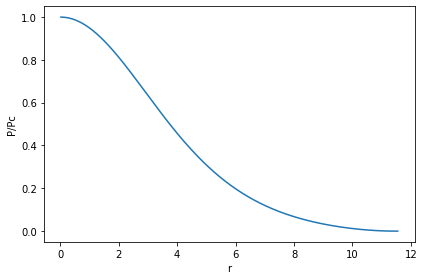

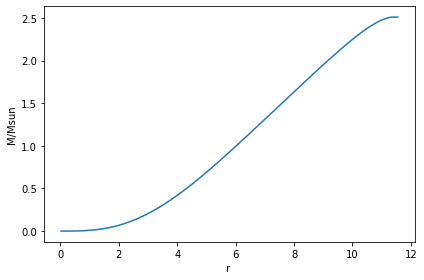

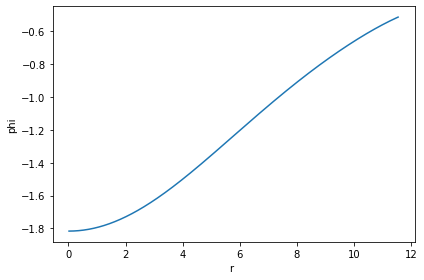

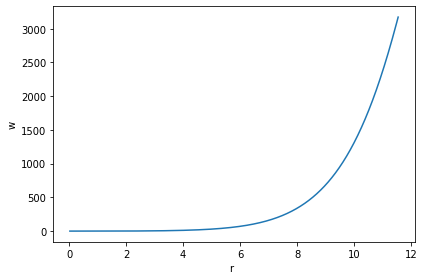

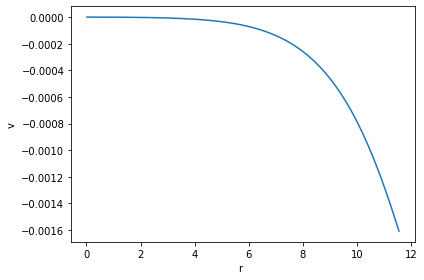

In [8]:
r_arr = r_arr/km2cm

plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, phi)
plt.xlabel("r ")
plt.ylabel("phi")
plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("w")
plt.show()

plt.figure()
plt.plot(r_arr, v)
plt.xlabel("r ")
plt.ylabel("v")
plt.show()

In [9]:
# plt.plot(p/p_c, EOS(p))
# plt.show()

<IPython.core.display.Javascript object>


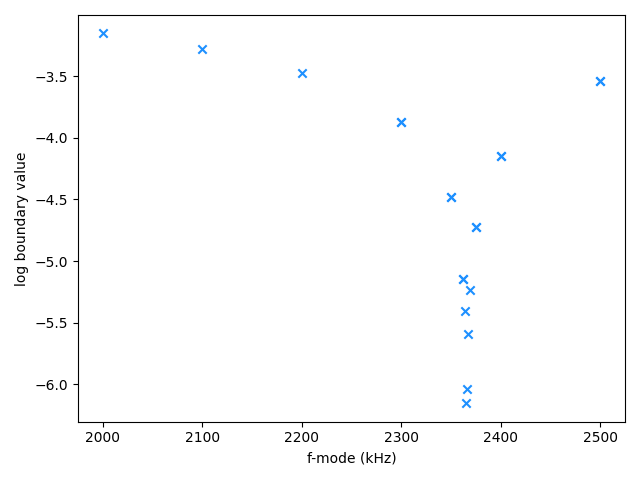

1.0281624221334519e-79 [1.07954145e-07] [1.10994395e-86]
1.0281624221334519e-79 [1.07954516e-07] [1.10994777e-86]
1.0281624221334643e-79 [1.08326459e-07] [1.11377194e-86]
1.0281624221334577e-79 [1.08140384e-07] [1.11185879e-86]
1.0281624221334577e-79 [1.08140871e-07] [1.11186379e-86]
1.0281624221334637e-79 [1.08327351e-07] [1.11378112e-86]
1.0281624221334637e-79 [1.08327838e-07] [1.11378612e-86]
1.028162422133524e-79 [1.10183949e-07] [1.13286995e-86]
1.028162422133524e-79 [1.10208454e-07] [1.13312191e-86]
1.0281624221334805e-79 [1.08850422e-07] [1.11915914e-86]
1.0281624221334805e-79 [1.08852337e-07] [1.11917882e-86]
1.0281624221334977e-79 [1.09378734e-07] [1.12459104e-86]
1.0281624221336253e-79 [1.13394435e-07] [1.16587897e-86]
1.0281624221336253e-79 [1.13395126e-07] [1.16588608e-86]
1.0281624221349671e-79 [1.59408298e-07] [1.63897622e-86]
1.0281624221349671e-79 [1.59933024e-07] [1.64437125e-86]
1.0281624221338967e-79 [1.22144916e-07] [1.25584813e-86]
1.0281624221338967e-79 [1.2215146

3.318829858687062e-74 [6.57897938e+17] [2.18345132e-56]
3.835015890482007e-74 [6.57749938e+17] [2.52248146e-56]
3.834921592969254e-74 [6.57749938e+17] [2.52241944e-56]
4.40989305562971e-74 [6.57601667e+17] [2.89995303e-56]
5.049235482655487e-74 [6.57453137e+17] [3.31963571e-56]
5.7585870549222335e-74 [6.57304354e+17] [3.78514435e-56]
6.54013696762181e-74 [6.57155329e+17] [4.29788586e-56]
7.393106593812139e-74 [6.57006066e+17] [4.85731588e-56]
7.392942552846814e-74 [6.57006066e+17] [4.8572081e-56]
8.314445200814487e-74 [6.56856574e+17] [5.46139799e-56]
8.314336761368734e-74 [6.56856573e+17] [5.46132676e-56]
9.300325723001253e-74 [6.56706856e+17] [6.10758767e-56]
1.1455092425852888e-73 [6.56401108e+17] [7.51913536e-56]
1.1456453072092975e-73 [6.56401108e+17] [7.52002849e-56]
1.0738390916712381e-73 [6.56500861e+17] [7.04976288e-56]
1.0738779723218326e-73 [6.56500861e+17] [7.05001814e-56]
1.2229542045241511e-73 [6.56294464e+17] [8.02618075e-56]
1.2229102383154537e-73 [6.56294464e+17] [8.02

2.166966287627717e-63 [6.39479208e+17] [1.38572989e-45]
2.1668341627451388e-63 [6.39479208e+17] [1.3856454e-45]
1.7546900422166315e-63 [6.39481013e+17] [1.12209097e-45]
1.7548030592249876e-63 [6.39481013e+17] [1.12216324e-45]
1.5344865712408933e-63 [6.39482239e+17] [9.81276908e-46]
1.5858399995443532e-63 [6.39481932e+17] [1.01411603e-45]
1.7384028643022755e-63 [6.39481097e+17] [1.11167577e-45]
2.0313115958008e-63 [6.39479746e+17] [1.29898262e-45]
2.031256472469787e-63 [6.39479746e+17] [1.29894737e-45]
2.3980306773401345e-63 [6.39478394e+17] [1.53348881e-45]
2.3981654007587962e-63 [6.39478394e+17] [1.53357496e-45]
2.268120147547569e-63 [6.39478838e+17] [1.45041484e-45]
2.2681545947350502e-63 [6.39478838e+17] [1.45043686e-45]
2.545518018076006e-63 [6.3947793e+17] [1.62780259e-45]
2.5455540421976096e-63 [6.3947793e+17] [1.62782563e-45]
2.872103831904548e-63 [6.39477022e+17] [1.83664441e-45]
3.259231029748392e-63 [6.39476115e+17] [2.0842004e-45]
3.259190854456968e-63 [6.39476115e+17] [2.08

2.0936826978388656e-55 [6.39458173e+17] [1.33882251e-37]
2.1246201045585372e-55 [6.39458173e+17] [1.35860569e-37]
2.1441208981052664e-55 [6.39458173e+17] [1.37107563e-37]
2.1324453709164746e-55 [6.39458173e+17] [1.36360962e-37]
2.1403073742116997e-55 [6.39458173e+17] [1.36863704e-37]
2.143332873260519e-55 [6.39458173e+17] [1.37057172e-37]
2.14518272872354e-55 [6.39458173e+17] [1.37175463e-37]
2.1440900980665738e-55 [6.39458173e+17] [1.37105594e-37]
2.144847663218288e-55 [6.39458173e+17] [1.37154037e-37]
2.1453101125313785e-55 [6.39458173e+17] [1.37183608e-37]
2.1457726886776407e-55 [6.39458173e+17] [1.37213188e-37]
2.1459533647776302e-55 [6.39458173e+17] [1.37224742e-37]
2.145848131509613e-55 [6.39458173e+17] [1.37218013e-37]
2.1459235777153357e-55 [6.39458173e+17] [1.37222837e-37]
2.1459703269125705e-55 [6.39458173e+17] [1.37225826e-37]
2.145942291921335e-55 [6.39458173e+17] [1.37224034e-37]
2.1459610063349126e-55 [6.39458173e+17] [1.3722523e-37]
2.1457786441113965e-55 [6.39458173e+17

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1011: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 [8.2337229e+15] [3.0010246e-63]
4.0337571754472913e-79 [1.06030613e+16] [4.27701744e-63]
4.4669813429051697e-79 [1.35365663e+16] [6.04675889e-63]
4.948067704984191e-79 [1.71402777e+16] [8.48112545e-63]
4.948067032448578e-79 [1.71404244e+16] [8.48119688e-63]
5.480675263979224e-79 [2.15338344e+16] [1.18019953e-62]
6.068588064905724e-79 [2.6850245e+16] [1.62943076e-62]
6.715645982963804e-79 [3.32357868e+16] [2.23199778e-62]
7.425882309276597e-79 [4.08498458e+16] [3.03346147e-62]
8.203458951524779e-79 [4.98626547e+16] [4.09046241e-62]
9.052937334159017e-79 [6.04547999e+16] [5.47293515e-62]
9.979258914847529e-79 [7.28130688e+16] [7.26620466e-62]
1.0988215552453049e-78 [8.71280387e+16] [9.5738167e-62]
1.2086579336067921e-78 [1.03587917e+17] [1.25202358e-61]
1.3282918992814925e-78 [1.22373276e+17] [1.62547431e-61]
1.4588175779946385e-78 [1.43647088e+17] [2.09554897e-61]
1.6017114854344443e-78 [1.67545446e+17] [2.68359465e-61]
1.7590094383773924e-78 [1.94161105e+17] [3.41531215e-61]
1.9336334

8.84237942265662e-72 [4.88142873e+17] [4.3163445e-54]
1.0461758211086997e-71 [4.87797367e+17] [5.10321811e-54]
1.0461550332832155e-71 [4.87797367e+17] [5.1031167e-54]
1.244599934253788e-71 [4.87451377e+17] [6.06681952e-54]
1.4892104079849488e-71 [4.87104906e+17] [7.25401695e-54]
1.489235622564092e-71 [4.87104906e+17] [7.25413977e-54]
1.7931603616517876e-71 [4.86757951e+17] [8.72835064e-54]
1.79310483079649e-71 [4.86757951e+17] [8.72808034e-54]
2.173611544168042e-71 [4.86410514e+17] [1.05726751e-53]
2.1736521885198418e-71 [4.86410514e+17] [1.05728728e-53]
2.6536388033286803e-71 [4.86062594e+17] [1.28983456e-53]
2.6536778051223745e-71 [4.86062594e+17] [1.28985352e-53]
3.265435854095956e-71 [4.85714192e+17] [1.58606854e-53]
3.2652786065466626e-71 [4.85714192e+17] [1.58599216e-53]
4.051340886636485e-71 [4.85365307e+17] [1.96638031e-53]
4.051587598725414e-71 [4.85365307e+17] [1.96650006e-53]
5.073432265897902e-71 [4.8501594e+17] [2.46069552e-53]
5.073197709948723e-71 [4.8501594e+17] [2.4605

3.4372091992805646e-61 [4.77513197e+17] [1.64131275e-43]
3.223218541329525e-61 [4.775133e+17] [1.53912972e-43]
3.223125377827406e-61 [4.775133e+17] [1.53908524e-43]
3.668466255106632e-61 [4.77513096e+17] [1.75174068e-43]
4.204288975920608e-61 [4.77512891e+17] [2.00760218e-43]
4.204387270059845e-61 [4.77512891e+17] [2.00764912e-43]
4.854146684386526e-61 [4.77512687e+17] [2.31791663e-43]
4.8540929079404285e-61 [4.77512687e+17] [2.31789095e-43]
5.652893047881713e-61 [4.77512482e+17] [2.69932699e-43]
5.6526647006865555e-61 [4.77512482e+17] [2.69921795e-43]
6.647601133588845e-61 [4.77512278e+17] [3.17431116e-43]
6.647962052825955e-61 [4.77512278e+17] [3.1744835e-43]
6.354819273912717e-61 [4.77512333e+17] [3.03450458e-43]
6.354950550807981e-61 [4.77512333e+17] [3.03456727e-43]
7.184129446253188e-61 [4.77512184e+17] [3.43050934e-43]
7.184179003890813e-61 [4.77512184e+17] [3.43053301e-43]
8.169718018104668e-61 [4.77512035e+17] [3.90113868e-43]
8.169625647933509e-61 [4.77512035e+17] [3.90109457

1.0281624221334519e-79 [4.52626836e-08] [4.65373904e-87]
1.0281624221334519e-79 [4.52628395e-08] [4.65375507e-87]
1.0281624221334643e-79 [4.54182681e-08] [4.66973565e-87]
1.0281624221334577e-79 [4.53406401e-08] [4.66175424e-87]
1.0281624221334577e-79 [4.5341103e-08] [4.66180183e-87]
1.0281624221334637e-79 [4.54191605e-08] [4.6698274e-87]
1.0281624221334637e-79 [4.54196237e-08] [4.66987504e-87]
1.028162422133524e-79 [4.61848225e-08] [4.7485499e-87]
1.028162422133524e-79 [4.6208163e-08] [4.75094967e-87]
1.0281624221334805e-79 [4.56377118e-08] [4.69229803e-87]
1.0281624221334805e-79 [4.56395346e-08] [4.69248544e-87]
1.0281624221334977e-79 [4.58602386e-08] [4.7151774e-87]
1.0281624221336253e-79 [4.75436478e-08] [4.88825921e-87]
1.0281624221336253e-79 [4.754434e-08] [4.88833038e-87]
1.0281624221349671e-79 [6.65412945e-08] [6.84152586e-87]
1.0281624221349671e-79 [6.7069462e-08] [6.89583005e-87]
1.0281624221338967e-79 [5.12091452e-08] [5.26513188e-87]
1.0281624221338967e-79 [5.12157054e-08] [

1.1456453072092975e-73 [3.3863991e+17] [3.87961224e-56]
1.0738390916712381e-73 [3.38826415e+17] [3.6384505e-56]
1.0738779723218326e-73 [3.38826416e+17] [3.63858224e-56]
1.2229542045241511e-73 [3.38440592e+17] [4.13897344e-56]
1.2229102383154537e-73 [3.38440591e+17] [4.13882464e-56]
1.3710938226364587e-73 [3.38054302e+17] [4.63504165e-56]
1.3710508586129061e-73 [3.38054302e+17] [4.6348964e-56]
1.5116768823941803e-73 [3.37667554e+17] [5.10444236e-56]
1.5116868402481547e-73 [3.37667554e+17] [5.10447598e-56]
1.6432886624660088e-73 [3.37280357e+17] [5.54248987e-56]
1.6432077263288072e-73 [3.37280357e+17] [5.54221688e-56]
1.768495973879502e-73 [3.36892713e+17] [5.95793407e-56]
1.7685675317131987e-73 [3.36892714e+17] [5.95817515e-56]
1.8916567836504302e-73 [3.36504628e+17] [6.36551263e-56]
1.8917268369490173e-73 [3.36504628e+17] [6.36574836e-56]
2.0174668222312243e-73 [3.36116103e+17] [6.78103086e-56]
2.0174456238133772e-73 [3.36116103e+17] [6.78095961e-56]
2.1511813804599188e-73 [3.35727138e

2.545518018076006e-63 [3.07695629e+17] [7.83244768e-46]
2.5455540421976096e-63 [3.07695629e+17] [7.83255852e-46]
2.872103831904548e-63 [3.07694001e+17] [8.83729119e-46]
3.259231029748392e-63 [3.07692373e+17] [1.00284053e-45]
3.259190854456968e-63 [3.07692373e+17] [1.00282817e-45]
3.723466500228075e-63 [3.07690745e+17] [1.14567618e-45]
3.723427393329684e-63 [3.07690745e+17] [1.14566415e-45]
4.2855118562477674e-63 [3.07689117e+17] [1.31860536e-45]
4.2856743400392206e-63 [3.07689117e+17] [1.31865535e-45]
4.972072524042719e-63 [3.07687489e+17] [1.52984451e-45]
4.972044690858353e-63 [3.07687489e+17] [1.52983595e-45]
5.820872825785641e-63 [3.07685861e+17] [1.79100027e-45]
5.820614562933887e-63 [3.07685861e+17] [1.79092081e-45]
6.886783586958625e-63 [3.07684234e+17] [2.11895473e-45]
6.886924038456437e-63 [3.07684234e+17] [2.11899794e-45]
8.243145849423679e-63 [3.07682606e+17] [2.53627259e-45]
8.243682634182922e-63 [3.07682606e+17] [2.53643775e-45]
7.813607142832385e-63 [3.07683079e+17] [2.404

2.1459235777153357e-55 [3.07660196e+17] [6.60215269e-38]
2.1459703269125705e-55 [3.07660196e+17] [6.60229652e-38]
2.145942291921335e-55 [3.07660196e+17] [6.60221027e-38]
2.1459610063349126e-55 [3.07660196e+17] [6.60226785e-38]
2.1457786441113965e-55 [3.07660196e+17] [6.60170679e-38]
2.145985398533758e-55 [3.07440516e+17] [6.59762858e-38]
2.1459849604491147e-55 [3.07377921e+17] [6.59628396e-38]
2.1454847981040507e-55 [3.07114398e+17] [6.58909272e-38]
2.145917086554947e-55 [3.06987247e+17] [6.58769179e-38]
2.145990065006727e-55 [3.06999082e+17] [6.5881698e-38]
1.0281624221334519e-79 [1.16779723e-08] [1.20068523e-87]
1.0281624221334519e-79 [1.16780126e-08] [1.20068937e-87]
1.0281624221334643e-79 [1.17174515e-08] [1.20474433e-87]
1.0281624221334577e-79 [1.169792e-08] [1.20273618e-87]
1.0281624221334577e-79 [1.16983704e-08] [1.20278249e-87]
1.0281624221334637e-79 [1.17183439e-08] [1.20483608e-87]
1.0281624221334637e-79 [1.17187946e-08] [1.20488243e-87]
1.028162422133524e-79 [1.18995764e-08]

3.9172446913056814e-78 [2.48016122e+17] [9.71539838e-61]
3.9172027695245807e-78 [2.47996957e+17] [9.71454365e-61]
4.779991662758178e-78 [2.59714105e+17] [1.24143126e-60]
4.780034047648089e-78 [2.59688403e+17] [1.24131941e-60]
6.272640577566425e-78 [2.63724614e+17] [1.65424971e-60]
6.274130376373064e-78 [2.63713056e+17] [1.6545701e-60]
6.274012796926039e-78 [2.63711282e+17] [1.65452796e-60]
5.492677025846627e-78 [2.63094788e+17] [1.4450947e-60]
5.492832671500673e-78 [2.63091904e+17] [1.44511981e-60]
6.501092954138114e-78 [2.63528239e+17] [1.71322158e-60]
6.501389800654537e-78 [2.63530829e+17] [1.71331664e-60]
8.008189190829708e-78 [2.60288418e+17] [2.0844389e-60]
8.008613259832149e-78 [2.60293154e+17] [2.0845872e-60]
7.531984415611005e-78 [2.61577531e+17] [1.97019789e-60]
7.532128705383081e-78 [2.61579397e+17] [1.97024968e-60]
8.960940087212914e-78 [2.57381542e+17] [2.30638058e-60]
8.960989764044428e-78 [2.57382609e+17] [2.30640292e-60]
1.1027623778659263e-77 [2.5063397e+17] [2.76389713

3.2652786065466626e-71 [1.43082037e+17] [4.67202715e-54]
4.051340886636485e-71 [1.42519917e+17] [5.77396766e-54]
4.051587598725414e-71 [1.42519917e+17] [5.77431928e-54]
5.073432265897902e-71 [1.4195721e+17] [7.20210291e-54]
5.073197709948723e-71 [1.4195721e+17] [7.20176994e-54]
6.41612892024901e-71 [1.41393917e+17] [9.072016e-54]
6.416217938404818e-71 [1.41393917e+17] [9.07214187e-54]
1.0698722661120791e-70 [1.40248017e+17] [1.50047464e-53]
1.0700773067449061e-70 [1.40248017e+17] [1.5007622e-53]
1.0700529054621972e-70 [1.40248017e+17] [1.50072798e-53]
8.315783788366059e-71 [1.40799295e+17] [1.1708565e-53]
8.316012787475237e-71 [1.40799295e+17] [1.17088874e-53]
1.0923975611382384e-70 [1.40204021e+17] [1.53158531e-53]
1.092370010958559e-70 [1.40204021e+17] [1.53154668e-53]
1.4561688082815883e-70 [1.39608095e+17] [2.03292953e-53]
1.4562307903058366e-70 [1.39608095e+17] [2.03301606e-53]
1.973565858067968e-70 [1.39011515e+17] [2.7434838e-53]
1.9735511192539632e-70 [1.39011515e+17] [2.743463

7.184129446253188e-61 [1.29916116e+17] [9.33334194e-44]
7.184179003890813e-61 [1.29916116e+17] [9.33340633e-44]
8.169718018104668e-61 [1.29915878e+17] [1.06137609e-43]
8.169625647933509e-61 [1.29915878e+17] [1.06136409e-43]
9.354836908258866e-61 [1.2991564e+17] [1.21533962e-43]
9.354648934060703e-61 [1.2991564e+17] [1.2153152e-43]
1.0794638215402206e-60 [1.29915401e+17] [1.40238976e-43]
1.0795070381346515e-60 [1.29915401e+17] [1.4024459e-43]
1.2560783698715012e-60 [1.29915163e+17] [1.63183626e-43]
1.4753098319625076e-60 [1.29914925e+17] [1.91664766e-43]
1.4752417494719077e-60 [1.29914925e+17] [1.91655921e-43]
1.751976129190922e-60 [1.29914687e+17] [2.2760743e-43]
1.7519880792861714e-60 [1.29914687e+17] [2.27608983e-43]
2.1059610418263356e-60 [1.29914449e+17] [2.73594768e-43]
2.1061343107004903e-60 [1.29914449e+17] [2.73617278e-43]
1.983828672943978e-60 [1.29914524e+17] [2.57728158e-43]
1.9838835977861257e-60 [1.29914524e+17] [2.57735294e-43]
2.260181666480038e-60 [1.29914362e+17] [2.93

1.0281624221334519e-79 [-5.99694117e-08] [-6.16582956e-87]
1.0281624221334519e-79 [-5.99696182e-08] [-6.16585079e-87]
1.0281624221334643e-79 [-6.01776238e-08] [-6.18723714e-87]
1.0281624221334577e-79 [-6.00732161e-08] [-6.17650234e-87]
1.0281624221334577e-79 [-6.00727924e-08] [-6.17645878e-87]
1.0281624221334637e-79 [-6.01767316e-08] [-6.18714541e-87]
1.0281624221334637e-79 [-6.01763075e-08] [-6.18710181e-87]
1.028162422133524e-79 [-6.12422819e-08] [-6.29670129e-87]
1.028162422133524e-79 [-6.12208964e-08] [-6.29450252e-87]
1.0281624221334805e-79 [-6.04693377e-08] [-6.21723007e-87]
1.0281624221334805e-79 [-6.04676689e-08] [-6.21705849e-87]
1.0281624221334977e-79 [-6.07600925e-08] [-6.24712438e-87]
1.0281624221336253e-79 [-6.29916016e-08] [-6.47655977e-87]
1.0281624221336253e-79 [-6.29909086e-08] [-6.47648851e-87]
1.0281624221349671e-79 [-8.93426047e-08] [-9.18587089e-87]
1.0281624221349671e-79 [-8.88086596e-08] [-9.13097266e-87]
1.0281624221338967e-79 [-6.78616137e-08] [-6.97727611e-87]

1.8916567836504302e-73 [-1.98543605e+17] [-3.75576357e-56]
1.8917268369490173e-73 [-1.98543605e+17] [-3.75590265e-56]
2.0174668222312243e-73 [-1.99234078e+17] [-4.01948143e-56]
2.0174456238133772e-73 [-1.99234078e+17] [-4.0194392e-56]
2.1511813804599188e-73 [-1.99925122e+17] [-4.30075199e-56]
2.1511677758402668e-73 [-1.99925122e+17] [-4.3007248e-56]
2.2990454788670827e-73 [-2.00616735e+17] [-4.61226997e-56]
2.4677233305590155e-73 [-2.01308918e+17] [-4.96774713e-56]
2.827310435691962e-73 [-2.02539254e+17] [-5.72641347e-56]
2.8276660679050085e-73 [-2.02539254e+17] [-5.72713375e-56]
2.6791783237870783e-73 [-2.0206385e+17] [-5.41365088e-56]
2.679257183032302e-73 [-2.0206385e+17] [-5.41381022e-56]
2.9208940213299916e-73 [-2.0281946e+17] [-5.92414149e-56]
2.920793252348447e-73 [-2.0281946e+17] [-5.92393712e-56]
3.193653098201824e-73 [-2.03575748e+17] [-6.50150319e-56]
3.193509549523699e-73 [-2.03575748e+17] [-6.50121097e-56]
3.498592877740346e-73 [-2.04332714e+17] [-7.14876978e-56]
3.8372386

6.886783586958625e-63 [-2.4924452e+17] [-1.71649307e-45]
6.886924038456437e-63 [-2.4924452e+17] [-1.71652808e-45]
8.243145849423679e-63 [-2.49247357e+17] [-2.05458231e-45]
8.243682634182922e-63 [-2.49247357e+17] [-2.05471611e-45]
7.813607142832385e-63 [-2.49246532e+17] [-1.94751448e-45]
7.813799888573446e-63 [-2.49246532e+17] [-1.94756252e-45]
8.921494125574483e-63 [-2.49248543e+17] [-2.22366941e-45]
8.921338839829366e-63 [-2.49248543e+17] [-2.22363071e-45]
1.0261811232742616e-62 [-2.49250555e+17] [-2.55776214e-45]
1.0261604433709414e-62 [-2.49250555e+17] [-2.5577106e-45]
1.1900573253472668e-62 [-2.49252567e+17] [-2.96624843e-45]
1.190110652783566e-62 [-2.49252567e+17] [-2.96638135e-45]
1.3924557136874356e-62 [-2.49254578e+17] [-3.47075961e-45]
1.3924469921227374e-62 [-2.49254578e+17] [-3.47073788e-45]
1.6460215024207819e-62 [-2.4925659e+17] [-4.10281706e-45]
1.6459219408105636e-62 [-2.4925659e+17] [-4.1025689e-45]
1.567838493713561e-62 [-2.49256019e+17] [-3.90793181e-45]
1.56780245580

1.0281624221334519e-79 [-2.33993928e-08] [-2.40583763e-87]
1.0281624221334519e-79 [-2.33994733e-08] [-2.40584592e-87]
1.0281624221334643e-79 [-2.34811791e-08] [-2.4142466e-87]
1.0281624221334577e-79 [-2.3440032e-08] [-2.41001601e-87]
1.0281624221334577e-79 [-2.34395947e-08] [-2.40997105e-87]
1.0281624221334637e-79 [-2.34802868e-08] [-2.41415486e-87]
1.0281624221334637e-79 [-2.34798491e-08] [-2.41410985e-87]
1.028162422133524e-79 [-2.39094584e-08] [-2.45828067e-87]
1.028162422133524e-79 [-2.38873935e-08] [-2.45601204e-87]
1.0281624221334805e-79 [-2.35952567e-08] [-2.42597563e-87]
1.0281624221334805e-79 [-2.35935344e-08] [-2.42579854e-87]
1.0281624221334977e-79 [-2.3707637e-08] [-2.43753015e-87]
1.0281624221336253e-79 [-2.45786426e-08] [-2.52708367e-87]
1.0281624221336253e-79 [-2.45779499e-08] [-2.52701244e-87]
1.0281624221349671e-79 [-3.51701858e-08] [-3.61606634e-87]
1.0281624221349671e-79 [-3.46382486e-08] [-3.56137456e-87]
1.0281624221338967e-79 [-2.64824138e-08] [-2.72282227e-87]
1.

1.488624612648736e-74 [-3.08467235e+15] [-4.59191918e-59]
1.4886538611306262e-74 [-3.0846722e+15] [-4.59200918e-59]
1.7803259269854377e-74 [-3.50598698e+15] [-6.24179953e-59]
1.7806454458129305e-74 [-3.50598572e+15] [-6.24291751e-59]
1.6730018542528485e-74 [-3.35735548e+15] [-5.61686195e-59]
1.6730800770006864e-74 [-3.35735515e+15] [-5.617124e-59]
1.8742825087288714e-74 [-3.63021618e+15] [-6.80405069e-59]
1.8743246343884254e-74 [-3.63021602e+15] [-6.80420332e-59]
2.0924780453001166e-74 [-3.90324844e+15] [-8.16746166e-59]
2.3282258181181185e-74 [-4.17644657e+15] [-9.72371073e-59]
2.582524330877046e-74 [-4.44980563e+15] [-1.14917313e-58]
2.856587085921555e-74 [-4.72332099e+15] [-1.34925777e-58]
3.3187984545285365e-74 [-5.14395887e+15] [-1.70717628e-58]
3.318829858687062e-74 [-5.14395882e+15] [-1.70719241e-58]
3.835015890482007e-74 [-5.56494532e+15] [-2.13416537e-58]
3.834921592969254e-74 [-5.56494545e+15] [-2.13411295e-58]
4.40989305562971e-74 [-5.98627105e+15] [-2.63988151e-58]
5.049235

4.6555433647940465e-65 [-5.54875269e+16] [-2.58324587e-48]
5.381249287975955e-65 [-5.55012501e+16] [-2.98666063e-48]
5.3812174442690666e-65 [-5.55012501e+16] [-2.98664295e-48]
6.274058884248395e-65 [-5.55149736e+16] [-3.48304213e-48]
6.273799531467217e-65 [-5.55149736e+16] [-3.48289815e-48]
7.3882745403342275e-65 [-5.55286974e+16] [-4.10261261e-48]
7.388496310825314e-65 [-5.55286974e+16] [-4.10273576e-48]
8.796456976510658e-65 [-5.55424214e+16] [-4.8857652e-48]
8.796883631830276e-65 [-5.55424214e+16] [-4.88600217e-48]
1.0607258732779435e-64 [-5.55561456e+16] [-5.89298411e-48]
1.0606303009327146e-64 [-5.55561456e+16] [-5.89245315e-48]
9.961835646225051e-65 [-5.55516585e+16] [-5.53396492e-48]
9.961566881389852e-65 [-5.55516585e+16] [-5.53381562e-48]
1.1354661814964154e-64 [-5.55608959e+16] [-6.30875183e-48]
1.3034600656726179e-64 [-5.55701333e+16] [-7.24334496e-48]
1.3034982908994726e-64 [-5.55701333e+16] [-7.24355737e-48]
1.5077479010320903e-64 [-5.55793708e+16] [-8.37996797e-48]
1.5077

2.5468574173176205e-56 [-5.57375316e+16] [-1.41955546e-39]
2.6826486613043893e-56 [-5.57375335e+16] [-1.4952422e-39]
2.966981882642465e-56 [-5.57375373e+16] [-1.65372263e-39]
2.967035221360762e-56 [-5.57375373e+16] [-1.65375236e-39]
3.293144645074652e-56 [-5.5737541e+16] [-1.83551785e-39]
3.294765611864424e-56 [-5.5737541e+16] [-1.83642133e-39]
3.1442425562948013e-56 [-5.57375394e+16] [-1.75252343e-39]
3.144469041135383e-56 [-5.57375394e+16] [-1.75264967e-39]
3.001385041891161e-56 [-5.57375377e+16] [-1.67289812e-39]
3.036294546452841e-56 [-5.57375381e+16] [-1.69235583e-39]
3.116946317234756e-56 [-5.5737539e+16] [-1.73730917e-39]
3.2699668430991455e-56 [-5.57375407e+16] [-1.8225991e-39]
3.4337031508582817e-56 [-5.57375424e+16] [-1.91386175e-39]
3.433721745522978e-56 [-5.57375424e+16] [-1.91387211e-39]
3.6092915777606313e-56 [-5.57375441e+16] [-2.01173049e-39]
3.6092692069490736e-56 [-5.57375441e+16] [-2.01171802e-39]
3.797717744332638e-56 [-5.57375458e+16] [-2.11675467e-39]
4.0003024376

2.920793252348447e-73 [-2.0281946e+17] [-5.92393712e-56]
3.193653098201824e-73 [-2.03575748e+17] [-6.50150319e-56]
3.193509549523699e-73 [-2.03575748e+17] [-6.50121097e-56]
3.498592877740346e-73 [-2.04332714e+17] [-7.14876978e-56]
3.837238693988175e-73 [-2.05090357e+17] [-7.86980653e-56]
4.780926562767368e-73 [-2.06875299e+17] [-9.89055614e-56]
4.780794274906215e-73 [-2.06875299e+17] [-9.89028247e-56]
5.995995841436265e-73 [-2.08663983e+17] [-1.25114838e-55]
5.997627937063677e-73 [-2.08663983e+17] [-1.25148893e-55]
5.4811155504567416e-73 [-2.07962225e+17] [-1.13986499e-55]
5.481334211094209e-73 [-2.07962225e+17] [-1.13991046e-55]
6.305425967561517e-73 [-2.09050533e+17] [-1.31815266e-55]
6.306133588880516e-73 [-2.09050532e+17] [-1.31830058e-55]
6.058737955489594e-73 [-2.08743024e+17] [-1.26471928e-55]
6.059007631305219e-73 [-2.08743024e+17] [-1.26477558e-55]
6.711262167765478e-73 [-2.09524534e+17] [-1.40617408e-55]
6.71105500101331e-73 [-2.09524534e+17] [-1.40613067e-55]
7.4493589005309

1.3924469921227374e-62 [-2.49254578e+17] [-3.47073788e-45]
1.6460215024207819e-62 [-2.4925659e+17] [-4.10281706e-45]
1.6459219408105636e-62 [-2.4925659e+17] [-4.1025689e-45]
1.567838493713561e-62 [-2.49256019e+17] [-3.90793181e-45]
1.5678024558047855e-62 [-2.49256019e+17] [-3.90784198e-45]
1.7757672516077393e-62 [-2.49257459e+17] [-4.42623234e-45]
1.7757805021051218e-62 [-2.49257459e+17] [-4.42626536e-45]
2.0242575266745128e-62 [-2.492589e+17] [-5.04564205e-45]
2.024292157232937e-62 [-2.492589e+17] [-5.04572837e-45]
2.3232543014354947e-62 [-2.49260341e+17] [-5.79095159e-45]
2.3232336913376467e-62 [-2.49260341e+17] [-5.79090022e-45]
2.6873984475790507e-62 [-2.49261781e+17] [-6.69865724e-45]
2.6873079387203845e-62 [-2.49261781e+17] [-6.69843164e-45]
3.1365214326463854e-62 [-2.49263222e+17] [-7.81819438e-45]
3.1366422959023318e-62 [-2.49263222e+17] [-7.81849565e-45]
3.6968099893350164e-62 [-2.49264663e+17] [-9.21484095e-45]
3.6969032966151096e-62 [-2.49264663e+17] [-9.21507353e-45]
4.4060

1.0281624221334519e-79 [-5.67412847e-09] [-5.83392568e-88]
1.0281624221334519e-79 [-5.67414801e-09] [-5.83394576e-88]
1.0281624221334643e-79 [-5.69463704e-09] [-5.85501181e-88]
1.0281624221334577e-79 [-5.684152e-09] [-5.84423149e-88]
1.0281624221334577e-79 [-5.68370807e-09] [-5.84377506e-88]
1.0281624221334637e-79 [-5.69374472e-09] [-5.85409436e-88]
1.0281624221334637e-79 [-5.69330041e-09] [-5.85363754e-88]
1.028162422133524e-79 [-5.81446743e-09] [-5.97821691e-88]
1.028162422133524e-79 [-5.79207323e-09] [-5.95519205e-88]
1.0281624221334805e-79 [-5.72261537e-09] [-5.88377808e-88]
1.0281624221334805e-79 [-5.72086711e-09] [-5.88198059e-88]
1.0281624221334977e-79 [-5.74853867e-09] [-5.91043145e-88]
1.0281624221336253e-79 [-5.96011651e-09] [-6.12796783e-88]
1.0281624221336253e-79 [-5.95942394e-09] [-6.12725575e-88]
1.0281624221349671e-79 [-8.91314606e-09] [-9.16416184e-88]
1.0281624221349671e-79 [-8.382182e-09] [-8.61824455e-88]
1.0281624221338967e-79 [-6.42616892e-09] [-6.6071454e-88]
1.02

5.639158054450688e-75 [8.84055636e+16] [4.98532946e-58]
6.37670611762552e-75 [8.80258695e+16] [5.613151e-58]
6.376834120500355e-75 [8.80258699e+16] [5.6132637e-58]
7.427428239903866e-75 [8.76456863e+16] [6.50982045e-58]
7.428682770248316e-75 [8.76456887e+16] [6.51092018e-58]
7.00740085942072e-75 [8.77822591e+16] [6.15125478e-58]
7.007672758156924e-75 [8.77822597e+16] [6.1514935e-58]
7.794100179037387e-75 [8.75384417e+16] [6.82283384e-58]
7.794446227111296e-75 [8.75384423e+16] [6.82313681e-58]
8.7422457152445895e-75 [8.72944137e+16] [7.63149214e-58]
8.742679065884136e-75 [8.72944143e+16] [7.63187048e-58]
9.854076654183139e-75 [8.70501792e+16] [8.57799139e-58]
9.852719740169533e-75 [8.70501779e+16] [8.57681006e-58]
9.524770966323576e-75 [8.71188815e+16] [8.29787393e-58]
9.524268790329685e-75 [8.7118881e+16] [8.29743639e-58]
1.0389185775783346e-74 [8.69432419e+16] [9.03269492e-58]
1.1336064539312174e-74 [8.67674991e+16] [9.8360197e-58]
1.236351895432678e-74 [8.65916558e+16] [1.07057758e-5

1.1354661814964154e-64 [3.82361439e+16] [4.34158483e-48]
1.3034600656726179e-64 [3.82276849e+16] [4.98282606e-48]
1.3034982908994726e-64 [3.82276849e+16] [4.98297219e-48]
1.5077479010320903e-64 [3.82192257e+16] [5.76249574e-48]
1.5077295978777086e-64 [3.82192257e+16] [5.76242578e-48]
1.7594361365014057e-64 [3.82107665e+16] [6.72294033e-48]
1.7593656060543177e-64 [3.82107665e+16] [6.72267083e-48]
2.0738780195146943e-64 [3.82023071e+16] [7.9226925e-48]
2.0739758033230325e-64 [3.82023071e+16] [7.92306606e-48]
2.4717561338514545e-64 [3.81938476e+16] [9.44058772e-48]
2.4718296701262073e-64 [3.81938476e+16] [9.44086858e-48]
2.984460551998108e-64 [3.81853881e+16] [1.13962784e-47]
2.9841597178293313e-64 [3.81853881e+16] [1.13951297e-47]
2.7950313617574723e-64 [3.81882575e+16] [1.06737377e-47]
2.79494769646118e-64 [3.81882575e+16] [1.06734182e-47]
3.180571513667432e-64 [3.81826673e+16] [1.21442704e-47]
3.6443794391930476e-64 [3.81770771e+16] [1.39131755e-47]
3.644455824139786e-64 [3.81770771e+1

3.6092915777606313e-56 [3.80743801e+16] [1.37421539e-39]
3.6092692069490736e-56 [3.80743801e+16] [1.37420688e-39]
3.797717744332638e-56 [3.80743785e+16] [1.44595743e-39]
4.0003024376198605e-56 [3.8074377e+16] [1.52309023e-39]
4.381602753244543e-56 [3.80743744e+16] [1.66826783e-39]
4.381566415440356e-56 [3.80743744e+16] [1.668254e-39]
4.815386934269807e-56 [3.80743717e+16] [1.83342832e-39]
4.814976213770594e-56 [3.80743717e+16] [1.83327194e-39]
4.651376088657259e-56 [3.80743727e+16] [1.77098227e-39]
4.651275060211226e-56 [3.80743727e+16] [1.7709438e-39]
4.944358221493418e-56 [3.8074371e+16] [1.88253329e-39]
4.944317164696815e-56 [3.8074371e+16] [1.88251766e-39]
5.263474410190382e-56 [3.80743693e+16] [2.00403469e-39]
5.612010866399591e-56 [3.80743676e+16] [2.13673765e-39]
5.993612203865398e-56 [3.80743659e+16] [2.28202984e-39]
6.744580782266388e-56 [3.8074363e+16] [2.56795617e-39]
6.744625196022369e-56 [3.8074363e+16] [2.56797308e-39]
7.631356565308651e-56 [3.80743601e+16] [2.90559018e-3

6.058737955489594e-73 [1.58573785e+17] [9.60757011e-56]
6.059007631305219e-73 [1.58573785e+17] [9.60799775e-56]
6.711262167765478e-73 [1.58023634e+17] [1.06053804e-55]
6.71105500101331e-73 [1.58023634e+17] [1.0605053e-55]
7.449358900530906e-73 [1.57472884e+17] [1.17307203e-55]
8.287206205431186e-73 [1.56921536e+17] [1.30044112e-55]
1.0023184647718024e-72 [1.55963833e+17] [1.5632543e-55]
1.0023078994008825e-72 [1.55963833e+17] [1.56323782e-55]
1.220377142222295e-72 [1.55004334e+17] [1.89163746e-55]
1.2204217530941206e-72 [1.55004334e+17] [1.89170661e-55]
1.49700582743635e-72 [1.54043037e+17] [2.30603325e-55]
1.4969564839575234e-72 [1.54043037e+17] [2.30595724e-55]
1.8507353447710246e-72 [1.53079946e+17] [2.83310466e-55]
1.850967253285188e-72 [1.53079946e+17] [2.83345967e-55]
1.7372523219012666e-72 [1.53363723e+17] [2.66431484e-55]
1.7373269422089822e-72 [1.53363723e+17] [2.66442928e-55]
2.0246725361607782e-72 [1.52683515e+17] [3.0913412e-55]
2.0246527612252257e-72 [1.52683515e+17] [3.09

3.1365214326463854e-62 [1.29927738e+17] [4.07521136e-45]
3.1366422959023318e-62 [1.29927738e+17] [4.0753684e-45]
3.6968099893350164e-62 [1.29926716e+17] [4.80314381e-45]
3.6969032966151096e-62 [1.29926716e+17] [4.80326504e-45]
4.4060249817012474e-62 [1.29925693e+17] [5.7245585e-45]
4.40572912527415e-62 [1.29925693e+17] [5.7241741e-45]
4.178249704915364e-62 [1.29925995e+17] [5.42863249e-45]
4.178153952859807e-62 [1.29925995e+17] [5.42850809e-45]
4.752090793184425e-62 [1.29925274e+17] [6.17416697e-45]
4.752062745753881e-62 [1.29925274e+17] [6.17413053e-45]
5.442161440880293e-62 [1.29924553e+17] [7.07070391e-45]
5.442310664573785e-62 [1.29924553e+17] [7.07089779e-45]
6.278519360022427e-62 [1.29923832e+17] [8.15729293e-45]
6.278475634678596e-62 [1.29923832e+17] [8.15723612e-45]
7.304462747211694e-62 [1.29923111e+17] [9.49018522e-45]
7.304175647064701e-62 [1.29923111e+17] [9.48981221e-45]
8.580748836098685e-62 [1.2992239e+17] [1.11483139e-44]
8.581024839721488e-62 [1.2992239e+17] [1.1148672

1.0281624221334519e-79 [-1.44901152e-08] [-1.48981919e-87]
1.0281624221334519e-79 [-1.44901651e-08] [-1.48982432e-87]
1.0281624221334643e-79 [-1.45411014e-08] [-1.4950614e-87]
1.0281624221334577e-79 [-1.4515366e-08] [-1.49241539e-87]
1.0281624221334577e-79 [-1.45149254e-08] [-1.49237008e-87]
1.0281624221334637e-79 [-1.45402091e-08] [-1.49496966e-87]
1.0281624221334637e-79 [-1.45397681e-08] [-1.49492431e-87]
1.028162422133524e-79 [-1.48143445e-08] [-1.52315524e-87]
1.028162422133524e-79 [-1.47921141e-08] [-1.52086959e-87]
1.0281624221334805e-79 [-1.46119028e-08] [-1.50234093e-87]
1.0281624221334805e-79 [-1.46101674e-08] [-1.50216251e-87]
1.0281624221334977e-79 [-1.4680827e-08] [-1.50942747e-87]
1.0281624221336253e-79 [-1.52203834e-08] [-1.56490263e-87]
1.0281624221336253e-79 [-1.52196908e-08] [-1.56483141e-87]
1.0281624221349671e-79 [-2.19725685e-08] [-2.25913692e-87]
1.0281624221349671e-79 [-2.14411204e-08] [-2.20449543e-87]
1.0281624221338967e-79 [-1.64015118e-08] [-1.68634181e-87]
1.

7.794446227111296e-75 [4.31910563e+16] [3.36650366e-58]
8.7422457152445895e-75 [4.29352977e+16] [3.75350922e-58]
8.742679065884136e-75 [4.29352982e+16] [3.75369533e-58]
9.854076654183139e-75 [4.26793326e+16] [4.20565415e-58]
9.852719740169533e-75 [4.26793312e+16] [4.20507489e-58]
9.524770966323576e-75 [4.27513337e+16] [4.07196662e-58]
9.524268790329685e-75 [4.27513332e+16] [4.07175188e-58]
1.0389185775783346e-74 [4.2567262e+16] [4.42239193e-58]
1.1336064539312174e-74 [4.23830868e+16] [4.80457408e-58]
1.236351895432678e-74 [4.21988107e+16] [5.21725796e-58]
1.6768483337728649e-74 [4.15303958e+16] [6.96401749e-58]
1.677219717983269e-74 [4.15303974e+16] [6.96556013e-58]
1.488624612648736e-74 [4.17965285e+16] [6.2219341e-58]
1.4886538611306262e-74 [4.17965286e+16] [6.22205637e-58]
1.7803259269854377e-74 [4.13938067e+16] [7.36944673e-58]
1.7806454458129305e-74 [4.1393808e+16] [7.37076957e-58]
1.6730018542528485e-74 [4.15358808e+16] [6.94896057e-58]
1.6730800770006864e-74 [4.15358812e+16] [6.

2.79494769646118e-64 [-8.46561966e+15] [-2.36609642e-48]
3.180571513667432e-64 [-8.4714657e+15] [-2.69441025e-48]
3.6443794391930476e-64 [-8.47731178e+15] [-3.08945407e-48]
3.644455824139786e-64 [-8.47731178e+15] [-3.08951883e-48]
4.206669971572803e-64 [-8.48315791e+15] [-3.56858457e-48]
4.2066232135082286e-64 [-8.48315791e+15] [-3.5685449e-48]
4.897685982390038e-64 [-8.4890041e+15] [-4.15764764e-48]
4.897488071510356e-64 [-8.4890041e+15] [-4.15747963e-48]
5.7578086668403964e-64 [-8.49485033e+15] [-4.89117228e-48]
5.758147782078971e-64 [-8.49485033e+15] [-4.89146036e-48]
5.4957953742653244e-64 [-8.49320478e+15] [-4.66769155e-48]
5.495914810605842e-64 [-8.49320478e+15] [-4.66779299e-48]
6.200526354154923e-64 [-8.49740548e+15] [-5.26883866e-48]
7.035609159371752e-64 [-8.50160621e+15] [-5.98139786e-48]
7.035526810500912e-64 [-8.50160621e+15] [-5.98132785e-48]
8.03648385481173e-64 [-8.50580697e+15] [-6.83567804e-48]
8.036356081783721e-64 [-8.50580697e+15] [-6.83556936e-48]
9.24817734440441

5.612010866399591e-56 [-8.58472157e+15] [-4.81775507e-40]
5.993612203865398e-56 [-8.58472332e+15] [-5.14535025e-40]
6.744580782266388e-56 [-8.58472637e+15] [-5.79003805e-40]
6.744625196022369e-56 [-8.58472637e+15] [-5.79007618e-40]
7.631356565308651e-56 [-8.58472941e+15] [-6.55131312e-40]
7.631463113463033e-56 [-8.58472941e+15] [-6.55140459e-40]
8.684985545345465e-56 [-8.58473246e+15] [-7.45582773e-40]
1.0931843053961944e-55 [-8.58473749e+15] [-9.38470029e-40]
1.0930056011410031e-55 [-8.58473749e+15] [-9.38316616e-40]
9.714549755288318e-56 [-8.58473497e+15] [-8.3396835e-40]
9.71433747601896e-56 [-8.58473497e+15] [-8.33950127e-40]
1.0927200975575565e-55 [-8.58473749e+15] [-9.38071518e-40]
1.092724370549997e-55 [-8.58473749e+15] [-9.38075187e-40]
1.236788496781728e-55 [-8.58474e+15] [-1.06175077e-39]
1.2368074165999305e-55 [-8.58474e+15] [-1.06176701e-39]
1.4090700795162219e-55 [-8.58474251e+15] [-1.20965038e-39]
1.40908475321881e-55 [-8.58474251e+15] [-1.20966298e-39]
1.6161520867432812

1.3108196776868934e-79 [-2.6635874e+13] [-3.49148277e-66]
1.3108198835937579e-79 [-2.66340306e+13] [-3.49124169e-66]
1.3431404731866435e-79 [-3.16625854e+13] [-4.25273e-66]
1.3431406711338651e-79 [-3.16605384e+13] [-4.25245568e-66]
1.3776665868112807e-79 [-3.71857825e+13] [-5.122961e-66]
1.3776667868663343e-79 [-3.71835127e+13] [-5.12264904e-66]
1.437642997002128e-79 [-4.69529289e+13] [-6.75015494e-66]
1.4376438018267742e-79 [-4.69429583e+13] [-6.7487253e-66]
1.5038978598701722e-79 [-5.76086183e+13] [-8.66374778e-66]
1.5768698648114422e-79 [-6.87262344e+13] [-1.08372328e-65]
1.657043176418608e-79 [-7.96190017e+13] [-1.31932123e-65]
1.7449367145143168e-79 [-8.93179366e+13] [-1.55854147e-65]
1.8411094537016468e-79 [-9.65250479e+13] [-1.77713178e-65]
1.946159598643367e-79 [-9.95143468e+13] [-1.93670801e-65]
2.0607275240153036e-79 [-9.61039246e+13] [-1.98044003e-65]
2.185490283406234e-79 [-8.35224641e+13] [-1.82537534e-65]
2.3211688464425654e-79 [-5.83919747e+13] [-1.35537633e-65]
2.468518

1.850967253285188e-72 [-2.78803392e+16] [-5.16055949e-56]
1.7372523219012666e-72 [-2.75384537e+16] [-4.78412426e-56]
1.7373269422089822e-72 [-2.75384537e+16] [-4.78432975e-56]
2.0246725361607782e-72 [-2.83579169e+16] [-5.74154956e-56]
2.0246527612252257e-72 [-2.8357917e+16] [-5.74149349e-56]
2.3702257394084723e-72 [-2.91783564e+16] [-6.91592915e-56]
2.370173606356032e-72 [-2.91783564e+16] [-6.91577703e-56]
2.7879413473747316e-72 [-2.9999772e+16] [-8.36376048e-56]
2.78803165364998e-72 [-2.9999772e+16] [-8.36403139e-56]
3.2958817223745387e-72 [-3.08221635e+16] [-1.01586205e-55]
3.295822708697707e-72 [-3.08221635e+16] [-1.01584386e-55]
4.59841288045502e-72 [-3.23864165e+16] [-1.48926115e-55]
4.597557359889504e-72 [-3.23864165e+16] [-1.48898408e-55]
4.00322129850361e-72 [-3.17472042e+16] [-1.27091084e-55]
4.003083763230603e-72 [-3.17472042e+16] [-1.27086718e-55]
4.897900201416245e-72 [-3.26734763e+16] [-1.60031426e-55]
4.898031858867663e-72 [-3.26734763e+16] [-1.60035728e-55]
6.03971394977

6.278475634678596e-62 [-5.57225244e+16] [-3.49852512e-45]
7.304462747211694e-62 [-5.57233897e+16] [-4.07029424e-45]
7.304175647064701e-62 [-5.57233897e+16] [-4.07013426e-45]
8.580748836098685e-62 [-5.5724255e+16] [-4.78155836e-45]
8.581024839721488e-62 [-5.5724255e+16] [-4.78171217e-45]
1.0188102422117393e-61 [-5.57251203e+16] [-5.67733233e-45]
1.0188534552835366e-61 [-5.57251203e+16] [-5.67757314e-45]
1.2246099220619956e-61 [-5.57259856e+16] [-6.82425949e-45]
1.2245082790911508e-61 [-5.57259856e+16] [-6.82369307e-45]
1.1532487765508052e-61 [-5.57257103e+16] [-6.42656072e-45]
1.1532191129939456e-61 [-5.57257103e+16] [-6.42639542e-45]
1.313826662729801e-61 [-5.57263003e+16] [-7.32146991e-45]
1.3138190656581801e-61 [-5.57263003e+16] [-7.32142758e-45]
1.5073781111339278e-61 [-5.57268903e+16] [-8.40014946e-45]
1.5074209524382276e-61 [-5.57268903e+16] [-8.4003882e-45]
1.7425626312344176e-61 [-5.57274803e+16] [-9.71086247e-45]
1.7425471190174495e-61 [-5.57274803e+16] [-9.71077602e-45]
2.0320

1.0281624221334519e-79 [-1.00704605e-08] [-1.0354069e-87]
1.0281624221334519e-79 [-1.00704951e-08] [-1.03541047e-87]
1.0281624221334643e-79 [-1.01061675e-08] [-1.03907817e-87]
1.0281624221334577e-79 [-1.00880775e-08] [-1.03721822e-87]
1.0281624221334577e-79 [-1.00876352e-08] [-1.03717275e-87]
1.0281624221334637e-79 [-1.01052752e-08] [-1.03898643e-87]
1.0281624221334637e-79 [-1.01048326e-08] [-1.03894091e-87]
1.028162422133524e-79 [-1.03025014e-08] [-1.05926448e-87]
1.028162422133524e-79 [-1.02801889e-08] [-1.05697039e-87]
1.0281624221334805e-79 [-1.01555008e-08] [-1.04415042e-87]
1.0281624221334805e-79 [-1.01537589e-08] [-1.04397134e-87]
1.0281624221334977e-79 [-1.02028677e-08] [-1.04902051e-87]
1.0281624221336253e-79 [-1.05780009e-08] [-1.08759031e-87]
1.0281624221336253e-79 [-1.05773083e-08] [-1.08751909e-87]
1.0281624221349671e-79 [-1.54255829e-08] [-1.58600047e-87]
1.0281624221349671e-79 [-1.48943775e-08] [-1.53138392e-87]
1.0281624221338967e-79 [-1.14006454e-08] [-1.17217152e-87]


1.7803259269854377e-74 [6.36673954e+16] [1.13348715e-57]
1.7806454458129305e-74 [6.36673967e+16] [1.1336906e-57]
1.6730018542528485e-74 [6.38062166e+16] [1.06747919e-57]
1.6730800770006864e-74 [6.3806217e+16] [1.0675291e-57]
1.8742825087288714e-74 [6.35513639e+16] [1.1911321e-57]
1.8743246343884254e-74 [6.3551364e+16] [1.19115887e-57]
2.0924780453001166e-74 [6.32963417e+16] [1.32446205e-57]
2.3282258181181185e-74 [6.30411558e+16] [1.46774047e-57]
2.582524330877046e-74 [6.27858115e+16] [1.62145886e-57]
2.856587085921555e-74 [6.25303134e+16] [1.78623286e-57]
3.3187984545285365e-74 [6.21373699e+16] [2.06221407e-57]
3.318829858687062e-74 [6.213737e+16] [2.06223359e-57]
3.835015890482007e-74 [6.17440845e+16] [2.36789545e-57]
3.834921592969254e-74 [6.17440843e+16] [2.36783722e-57]
4.40989305562971e-74 [6.13504667e+16] [2.70548997e-57]
5.049235482655487e-74 [6.09565254e+16] [3.07783851e-57]
5.7585870549222335e-74 [6.05622675e+16] [3.4875309e-57]
6.54013696762181e-74 [6.01676994e+16] [3.935049

7.035609159371752e-64 [1.48878334e+16] [1.04744977e-47]
7.035526810500912e-64 [1.48878334e+16] [1.04743751e-47]
8.03648385481173e-64 [1.48837248e+16] [1.19612814e-47]
8.036356081783721e-64 [1.48837248e+16] [1.19610912e-47]
9.248177344404414e-64 [1.48796161e+16] [1.37609329e-47]
9.24850038333481e-64 [1.48796161e+16] [1.37614136e-47]
1.0728584553101417e-63 [1.48755075e+16] [1.5959314e-47]
1.2557603963812038e-63 [1.48713988e+16] [1.86749137e-47]
1.2557091215221853e-63 [1.48713988e+16] [1.86741511e-47]
1.4854073820653056e-63 [1.48672901e+16] [2.20839825e-47]
2.1653339669031046e-63 [1.48589692e+16] [3.21746307e-47]
2.166966287627717e-63 [1.48589692e+16] [3.21988853e-47]
2.1668341627451388e-63 [1.48589692e+16] [3.21969221e-47]
1.7546900422166315e-63 [1.48634693e+16] [2.60807816e-47]
1.7548030592249876e-63 [1.48634693e+16] [2.60824615e-47]
1.5344865712408933e-63 [1.4866526e+16] [2.28124844e-47]
1.5858399995443532e-63 [1.48657618e+16] [2.35747197e-47]
1.7384028643022755e-63 [1.48636783e+16] [2

1.236788496781728e-55 [1.48065234e+16] [1.83125378e-39]
1.2368074165999305e-55 [1.48065234e+16] [1.83128179e-39]
1.4090700795162219e-55 [1.48065209e+16] [2.08634256e-39]
1.40908475321881e-55 [1.48065209e+16] [2.08636429e-39]
1.6161520867432812e-55 [1.48065185e+16] [2.39295857e-39]
1.6161627944498201e-55 [1.48065185e+16] [2.39297442e-39]
1.8661477516573312e-55 [1.4806516e+16] [2.76311465e-39]
2.050700303576247e-55 [1.4806512e+16] [3.03637187e-39]
1.9364781344599864e-55 [1.48065154e+16] [2.86724933e-39]
2.0102756023734636e-55 [1.48065148e+16] [2.97651754e-39]
2.051435847530312e-55 [1.48065144e+16] [3.03746145e-39]
2.0936826978388656e-55 [1.48065141e+16] [3.10001424e-39]
2.1246201045585372e-55 [1.48065139e+16] [3.14582171e-39]
2.1441208981052664e-55 [1.48065135e+16] [3.1746955e-39]
2.1324453709164746e-55 [1.48065138e+16] [3.15740818e-39]
2.1403073742116997e-55 [1.48065138e+16] [3.16904906e-39]
2.143332873260519e-55 [1.48065137e+16] [3.17352876e-39]
2.14518272872354e-55 [1.48065137e+16] [3

2.3211688464425654e-79 [3.43479421e+14] [7.97273732e-65]
2.4685185861983653e-79 [4.65814682e+14] [1.1498722e-64]
2.628336846632156e-79 [6.22295677e+14] [1.63560266e-64]
2.801459353431265e-79 [8.20280127e+14] [2.29798143e-64]
2.9887452138066044e-79 [1.06820755e+15] [3.19260022e-64]
3.1911052682184005e-79 [1.37580944e+15] [4.39035275e-64]
3.409469382579203e-79 [1.75407041e+15] [5.98044934e-64]
3.6447966967300215e-79 [2.21546878e+15] [8.07493328e-64]
4.0337571754472913e-79 [3.09914896e+15] [1.25012144e-63]
4.4669813429051697e-79 [4.25818632e+15] [1.90212388e-63]
4.948067704984191e-79 [5.75527405e+15] [2.84774857e-63]
4.948067032448578e-79 [5.75542137e+15] [2.84782107e-63]
5.480675263979224e-79 [7.66182831e+15] [4.19919929e-63]
6.068588064905724e-79 [1.00573506e+16] [6.10339178e-63]
6.715645982963804e-79 [1.30288159e+16] [8.74969149e-63]
7.425882309276597e-79 [1.66702302e+16] [1.23791168e-62]
8.203458951524779e-79 [2.10797268e+16] [1.72926674e-62]
9.052937334159017e-79 [2.63586833e+16] [2.

4.00322129850361e-72 [6.00271005e+16] [2.40301767e-55]
4.003083763230603e-72 [6.00271005e+16] [2.40293511e-55]
4.897900201416245e-72 [5.9180126e+16] [2.89858351e-55]
4.898031858867663e-72 [5.9180126e+16] [2.89866142e-55]
6.039713949770308e-72 [5.83319735e+16] [3.52308434e-55]
6.039668826129237e-72 [5.83319735e+16] [3.52305802e-55]
7.5123915226249e-72 [5.74826431e+16] [4.31832121e-55]
7.5120302021904e-72 [5.74826431e+16] [4.31811351e-55]
9.428569105455773e-72 [5.66321348e+16] [5.33959997e-55]
9.429262594055012e-72 [5.66321349e+16] [5.33999271e-55]
8.842118893694979e-72 [5.68690924e+16] [5.02843276e-55]
8.84237942265662e-72 [5.68690924e+16] [5.02858092e-55]
1.0461758211086997e-71 [5.62549284e+16] [5.88525459e-55]
1.0461550332832155e-71 [5.62549284e+16] [5.88513765e-55]
1.244599934253788e-71 [5.56401512e+16] [6.92497285e-55]
1.4892104079849488e-71 [5.50247607e+16] [8.19434463e-55]
1.489235622564092e-71 [5.50247607e+16] [8.19448337e-55]
1.7931603616517876e-71 [5.44087568e+16] [9.7563626e-5

1.5074209524382276e-61 [3.80841363e+16] [5.7408825e-45]
1.7425626312344176e-61 [3.8083596e+16] [6.63630512e-45]
1.7425471190174495e-61 [3.8083596e+16] [6.63624605e-45]
2.03202957463637e-61 [3.80830557e+16] [7.73858955e-45]
2.031943689114033e-61 [3.80830557e+16] [7.73826247e-45]
2.393307823668754e-61 [3.80825154e+16] [9.11431821e-45]
2.3934128722779405e-61 [3.80825154e+16] [9.11471826e-45]
2.8499705298447174e-61 [3.80819751e+16] [1.08532507e-44]
2.8500676335276127e-61 [3.80819751e+16] [1.08536205e-44]
3.437541846332469e-61 [3.80814349e+16] [1.30906526e-44]
3.4372091992805646e-61 [3.80814349e+16] [1.30893858e-44]
3.223218541329525e-61 [3.80816158e+16] [1.2274537e-44]
3.223125377827406e-61 [3.80816158e+16] [1.22741822e-44]
3.668466255106632e-61 [3.80812564e+16] [1.39699804e-44]
4.204288975920608e-61 [3.8080897e+16] [1.60103096e-44]
4.204387270059845e-61 [3.8080897e+16] [1.60106839e-44]
4.854146684386526e-61 [3.80805376e+16] [1.84848516e-44]
4.8540929079404285e-61 [3.80805376e+16] [1.84846

1.0281624221334519e-79 [-1.22773725e-08] [-1.2623133e-87]
1.0281624221334519e-79 [-1.22774148e-08] [-1.26231765e-87]
1.0281624221334643e-79 [-1.2320709e-08] [-1.26676901e-87]
1.0281624221334577e-79 [-1.22988014e-08] [-1.26451654e-87]
1.0281624221334577e-79 [-1.22983599e-08] [-1.26447115e-87]
1.0281624221334637e-79 [-1.23198167e-08] [-1.26667726e-87]
1.0281624221334637e-79 [-1.23193749e-08] [-1.26663183e-87]
1.028162422133524e-79 [-1.25554468e-08] [-1.29090386e-87]
1.028162422133524e-79 [-1.25331753e-08] [-1.28861399e-87]
1.0281624221334805e-79 [-1.23807622e-08] [-1.27294344e-87]
1.0281624221334805e-79 [-1.23790236e-08] [-1.27276469e-87]
1.0281624221334977e-79 [-1.24388936e-08] [-1.27892029e-87]
1.0281624221336253e-79 [-1.28961299e-08] [-1.32593162e-87]
1.0281624221336253e-79 [-1.28954373e-08] [-1.3258604e-87]
1.0281624221349671e-79 [-1.86947571e-08] [-1.92212467e-87]
1.0281624221349671e-79 [-1.81634305e-08] [-1.86749567e-87]
1.0281624221338967e-79 [-1.38977799e-08] [-1.4289175e-87]
1.0

3.834921592969254e-74 [5.05995228e+16] [1.94045202e-57]
4.40989305562971e-74 [5.02013174e+16] [2.21382441e-57]
5.049235482655487e-74 [4.98027872e+16] [2.51466e-57]
5.7585870549222335e-74 [4.94039393e+16] [2.84496885e-57]
6.54013696762181e-74 [4.90047798e+16] [3.20497972e-57]
7.393106593812139e-74 [4.86053145e+16] [3.59344271e-57]
7.392942552846814e-74 [4.86053144e+16] [3.59336297e-57]
8.314445200814487e-74 [4.8205548e+16] [4.00802387e-57]
8.314336761368734e-74 [4.82055479e+16] [4.00797159e-57]
9.300325723001253e-74 [4.78054849e+16] [4.44606581e-57]
1.1455092425852888e-73 [4.69893909e+16] [5.38267816e-57]
1.1456453072092975e-73 [4.69893913e+16] [5.38331757e-57]
1.0738390916712381e-73 [4.72555198e+16] [5.07448245e-57]
1.0738779723218326e-73 [4.725552e+16] [5.0746662e-57]
1.2229542045241511e-73 [4.67050127e+16] [5.71180917e-57]
1.2229102383154537e-73 [4.67050126e+16] [5.71160381e-57]
1.3710938226364587e-73 [4.61539714e+16] [6.32814251e-57]
1.3710508586129061e-73 [4.61539713e+16] [6.327944

1.7546900422166315e-63 [3.18390505e+15] [5.58676649e-48]
1.7548030592249876e-63 [3.18390505e+15] [5.58712632e-48]
1.5344865712408933e-63 [3.18699591e+15] [4.89040243e-48]
1.5858399995443532e-63 [3.1862232e+15] [5.05284019e-48]
1.7384028643022755e-63 [3.1841164e+15] [5.53527707e-48]
2.0313115958008e-63 [3.180709e+15] [6.46101107e-48]
2.031256472469787e-63 [3.180709e+15] [6.46083574e-48]
2.3980306773401345e-63 [3.17730158e+15] [7.61926667e-48]
2.3981654007587962e-63 [3.17730158e+15] [7.61969473e-48]
2.268120147547569e-63 [3.17842011e+15] [7.2090387e-48]
2.2681545947350502e-63 [3.17842011e+15] [7.20914819e-48]
2.545518018076006e-63 [3.17613122e+15] [8.08489925e-48]
2.5455540421976096e-63 [3.17613122e+15] [8.08501367e-48]
2.872103831904548e-63 [3.17384232e+15] [9.1156047e-48]
3.259231029748392e-63 [3.17155341e+15] [1.03368253e-47]
3.259190854456968e-63 [3.17155341e+15] [1.03366979e-47]
3.723466500228075e-63 [3.1692645e+15] [1.18006502e-47]
3.723427393329684e-63 [3.1692645e+15] [1.18005263e

2.1441208981052664e-55 [3.12631129e+15] [6.70318937e-40]
2.1324453709164746e-55 [3.12631161e+15] [6.66668873e-40]
2.1403073742116997e-55 [3.12631155e+15] [6.69126767e-40]
2.143332873260519e-55 [3.12631153e+15] [6.70072627e-40]
2.14518272872354e-55 [3.12631149e+15] [6.70650942e-40]
2.1440900980665738e-55 [3.12631152e+15] [6.70309358e-40]
2.144847663218288e-55 [3.12631152e+15] [6.70546196e-40]
2.1453101125313785e-55 [3.12631152e+15] [6.70690771e-40]
2.1457726886776407e-55 [3.12631151e+15] [6.70835386e-40]
2.1459533647776302e-55 [3.12631151e+15] [6.7089187e-40]
2.145848131509613e-55 [3.12631151e+15] [6.70858971e-40]
2.1459235777153357e-55 [3.12631151e+15] [6.70882558e-40]
2.1459703269125705e-55 [3.12631151e+15] [6.70897173e-40]
2.145942291921335e-55 [3.12631151e+15] [6.70888409e-40]
2.1459610063349126e-55 [3.12631151e+15] [6.70894259e-40]
2.1457786441113965e-55 [3.1263115e+15] [6.70837246e-40]
2.145985398533758e-55 [2.89962411e+15] [6.222551e-40]
2.1459849604491147e-55 [2.83503282e+15] [6

6.715645982963804e-79 [1.08832442e+16] [7.30880154e-63]
7.425882309276597e-79 [1.41028441e+16] [1.04726061e-62]
8.203458951524779e-79 [1.8023562e+16] [1.47855551e-62]
9.052937334159017e-79 [2.27383653e+16] [2.05848996e-62]
9.979258914847529e-79 [2.83380355e+16] [2.82792594e-62]
1.0988215552453049e-78 [3.49081767e+16] [3.8357857e-62]
1.2086579336067921e-78 [4.25227011e+16] [5.13954e-62]
1.3282918992814925e-78 [5.1238016e+16] [6.80590416e-62]
1.4588175779946385e-78 [6.10832053e+16] [8.91092537e-62]
1.6017114854344443e-78 [7.20503624e+16] [1.15403893e-61]
1.7590094383773924e-78 [8.40792375e+16] [1.47896172e-61]
1.933633487882578e-78 [9.704123e+16] [1.87642172e-61]
2.129909589308622e-78 [1.10713972e+17] [2.35810752e-61]
2.3544935879119417e-78 [1.24753949e+17] [2.93732374e-61]
2.6181180703404244e-78 [1.38650763e+17] [3.63004069e-61]
2.618111892016371e-78 [1.3864731e+17] [3.6299417e-61]
2.9390100049413925e-78 [1.51673865e+17] [4.45771007e-61]
2.939002785371121e-78 [1.51667403e+17] [4.4575092

5.481334211094209e-73 [2.50510716e+16] [1.37313296e-56]
6.305425967561517e-73 [2.41673447e+16] [1.52385403e-56]
6.306133588880516e-73 [2.41673449e+16] [1.52402506e-56]
6.058737955489594e-73 [2.44170599e+16] [1.47936568e-56]
6.059007631305219e-73 [2.441706e+16] [1.47943153e-56]
6.711262167765478e-73 [2.37824085e+16] [1.59609979e-56]
6.71105500101331e-73 [2.37824085e+16] [1.59605051e-56]
7.449358900530906e-73 [2.31471173e+16] [1.72431184e-56]
8.287206205431186e-73 [2.25111866e+16] [1.86554845e-56]
1.0023184647718024e-72 [2.14066835e+16] [2.14563141e-56]
1.0023078994008825e-72 [2.14066835e+16] [2.14560879e-56]
1.220377142222295e-72 [2.03002586e+16] [2.47739716e-56]
1.2204217530941206e-72 [2.03002586e+16] [2.47748772e-56]
1.49700582743635e-72 [1.91919132e+16] [2.8730406e-56]
1.4969564839575234e-72 [1.91919132e+16] [2.87294589e-56]
1.8507353447710246e-72 [1.8081648e+16] [3.3464345e-56]
1.850967253285188e-72 [1.80816481e+16] [3.34685384e-56]
1.7372523219012666e-72 [1.84087747e+16] [3.1980686

1.0125786273012688e-65 [-8.15101184e+15] [-8.25354038e-50]
1.1823394834435414e-65 [-8.17641931e+15] [-9.66730339e-50]
1.394341817857444e-65 [-8.20182772e+15] [-1.14361514e-49]
1.3942654409757617e-65 [-8.20182772e+15] [-1.14355249e-49]
1.3316235647881631e-65 [-8.19490876e+15] [-1.09125336e-49]
1.331595181971243e-65 [-8.19490876e+15] [-1.0912301e-49]
1.5086823129320362e-65 [-8.21339869e+15] [-1.23914093e-49]
1.7203927883403392e-65 [-8.23188913e+15] [-1.41620827e-49]
1.7204279984785558e-65 [-8.23188913e+15] [-1.41623725e-49]
1.9753109941130803e-65 [-8.25038005e+15] [-1.62970664e-49]
1.975297010639925e-65 [-8.25038005e+15] [-1.62969511e-49]
2.285843557317823e-65 [-8.26887148e+15] [-1.89013466e-49]
2.285763030721755e-65 [-8.26887148e+15] [-1.89006807e-49]
2.669097560687608e-65 [-8.2873634e+15] [-2.21197814e-49]
2.6691825023895197e-65 [-8.2873634e+15] [-2.21204854e-49]
3.1475979560400063e-65 [-8.30585581e+15] [-2.61434948e-49]
3.1477046259516487e-65 [-8.30585581e+15] [-2.61443807e-49]
3.7536

1.1991073174730492e-56 [-8.58466427e+15] [-1.02939337e-40]
1.1996101303643344e-56 [-8.58466427e+15] [-1.02982502e-40]
1.1995825909529553e-56 [-8.58466427e+15] [-1.02980138e-40]
1.0846158910159027e-56 [-8.58465919e+15] [-9.31105777e-41]
1.0847356286092974e-56 [-8.58465919e+15] [-9.31208568e-41]
9.502610294956292e-57 [-8.58465221e+15] [-8.15766044e-41]
9.816419417647048e-57 [-8.58465395e+15] [-8.42705638e-41]
1.038692913148107e-56 [-8.58465694e+15] [-8.91682232e-41]
1.1354126566857047e-56 [-8.58466152e+15] [-9.74713334e-41]
1.2450865724208416e-56 [-8.5846661e+15] [-1.06886525e-40]
1.245108518050916e-56 [-8.5846661e+15] [-1.06888409e-40]
1.3703100834445445e-56 [-8.58467068e+15] [-1.17636608e-40]
1.3702871092121062e-56 [-8.58467068e+15] [-1.17634636e-40]
1.5138330837492833e-56 [-8.58467525e+15] [-1.29957654e-40]
1.679134390114393e-56 [-8.58467983e+15] [-1.44148311e-40]
2.0008696321934526e-56 [-8.58468719e+15] [-1.71768399e-40]
2.0009401485899062e-56 [-8.58468719e+15] [-1.71774453e-40]
2.41

1.0738779723218326e-73 [5.28507207e+16] [5.67552248e-57]
1.2229542045241511e-73 [5.23033737e+16] [6.39646308e-57]
1.2229102383154537e-73 [5.23033736e+16] [6.3962331e-57]
1.3710938226364587e-73 [5.17554939e+16] [7.0961638e-57]
1.3710508586129061e-73 [5.17554938e+16] [7.09594142e-57]
1.5116768823941803e-73 [5.12070889e+16] [7.74085725e-57]
1.5116868402481547e-73 [5.12070889e+16] [7.74090824e-57]
1.6432886624660088e-73 [5.06581654e+16] [8.32459889e-57]
1.6432077263288072e-73 [5.06581652e+16] [8.32418884e-57]
1.768495973879502e-73 [5.01087267e+16] [8.86170814e-57]
1.7685675317131987e-73 [5.01087269e+16] [8.86206675e-57]
1.8916567836504302e-73 [4.95587767e+16] [9.37481961e-57]
1.8917268369490173e-73 [4.95587769e+16] [9.37516682e-57]
2.0174668222312243e-73 [4.90083168e+16] [9.88726532e-57]
2.0174456238133772e-73 [4.90083168e+16] [9.88716142e-57]
2.1511813804599188e-73 [4.84573474e+16] [1.04240543e-56]
2.1511677758402668e-73 [4.84573474e+16] [1.04239884e-56]
2.2990454788670827e-73 [4.79058689

2.872103831904548e-63 [9.01753742e+15] [2.58993038e-47]
3.259231029748392e-63 [9.0152612e+15] [2.9382819e-47]
3.259190854456968e-63 [9.0152612e+15] [2.93824568e-47]
3.723466500228075e-63 [9.01298497e+15] [3.35595476e-47]
3.723427393329684e-63 [9.01298497e+15] [3.35591951e-47]
4.2855118562477674e-63 [9.01070873e+15] [3.86154991e-47]
4.2856743400392206e-63 [9.01070873e+15] [3.86169632e-47]
4.972072524042719e-63 [9.00843248e+15] [4.47905796e-47]
4.972044690858353e-63 [9.00843248e+15] [4.47903289e-47]
5.820872825785641e-63 [9.00615623e+15] [5.242369e-47]
5.820614562933887e-63 [9.00615623e+15] [5.24213641e-47]
6.886783586958625e-63 [9.00387997e+15] [6.20077728e-47]
6.886924038456437e-63 [9.00387997e+15] [6.20090374e-47]
8.243145849423679e-63 [9.0016037e+15] [7.42015321e-47]
8.243682634182922e-63 [9.0016037e+15] [7.42063641e-47]
7.813607142832385e-63 [9.00226585e+15] [7.03401687e-47]
7.813799888573446e-63 [9.00226585e+15] [7.03419039e-47]
8.921494125574483e-63 [9.00065173e+15] [8.02992615e-4

2.145942291921335e-55 [8.97027001e+15] [1.92496818e-39]
2.1459610063349126e-55 [8.97027001e+15] [1.92498497e-39]
2.1457786441113965e-55 [8.97027e+15] [1.92482138e-39]
2.145985398533758e-55 [8.74371707e+15] [1.87638892e-39]
2.1459849604491147e-55 [8.67916409e+15] [1.86253556e-39]
2.1454847981040507e-55 [8.40739509e+15] [1.80379384e-39]
2.145917086554947e-55 [8.27626503e+15] [1.77601785e-39]
2.145990065006727e-55 [8.28847048e+15] [1.77869753e-39]
1.0281624221334519e-79 [-1.00704605e-08] [-1.0354069e-87]
1.0281624221334519e-79 [-1.00704951e-08] [-1.03541047e-87]
1.0281624221334643e-79 [-1.01061675e-08] [-1.03907817e-87]
1.0281624221334577e-79 [-1.00880775e-08] [-1.03721822e-87]
1.0281624221334577e-79 [-1.00876352e-08] [-1.03717275e-87]
1.0281624221334637e-79 [-1.01052752e-08] [-1.03898643e-87]
1.0281624221334637e-79 [-1.01048326e-08] [-1.03894091e-87]
1.028162422133524e-79 [-1.03025014e-08] [-1.05926448e-87]
1.028162422133524e-79 [-1.02801889e-08] [-1.05697039e-87]
1.0281624221334805e-79 

7.532128705383081e-78 [1.76433964e+17] [1.32892333e-60]
8.960940087212914e-78 [1.68625185e+17] [1.51104018e-60]
8.960989764044428e-78 [1.68626218e+17] [1.51105781e-60]
1.1027623778659263e-77 [1.58212818e+17] [1.74471143e-60]
1.1027780925071325e-77 [1.58214314e+17] [1.7447528e-60]
1.4113469088389835e-77 [1.44906901e+17] [2.04513907e-60]
1.4117881308151896e-77 [1.44920403e+17] [2.04596904e-60]
1.411760708806155e-77 [1.4491974e+17] [2.04591994e-60]
1.2488282966873124e-77 [1.51599474e+17] [1.89321713e-60]
1.2488930951684714e-77 [1.5160214e+17] [1.89334866e-60]
1.129673265764811e-77 [1.56956652e+17] [1.77309734e-60]
1.1577415100412517e-77 [1.55666824e+17] [1.80221944e-60]
1.227335639176775e-77 [1.52553909e+17] [1.8723485e-60]
1.3032305981569077e-77 [1.49264461e+17] [1.94526013e-60]
1.3891781716091458e-77 [1.45797364e+17] [2.02538515e-60]
1.3891127316182126e-77 [1.45795461e+17] [2.02526331e-60]
1.3570285192591483e-77 [1.47061792e+17] [1.99567045e-60]
1.357007226110746e-77 [1.47061133e+17] [1

5.073432265897902e-71 [2.83555535e+16] [1.4385998e-54]
5.073197709948723e-71 [2.83555535e+16] [1.43853329e-54]
6.41612892024901e-71 [2.77215802e+16] [1.77865232e-54]
6.416217938404818e-71 [2.77215802e+16] [1.778677e-54]
1.0698722661120791e-70 [2.64320169e+16] [2.82788819e-54]
1.0700773067449061e-70 [2.64320169e+16] [2.82843015e-54]
1.0700529054621972e-70 [2.64320169e+16] [2.82836565e-54]
8.315783788366059e-71 [2.70523898e+16] [2.24961825e-54]
8.316012787475237e-71 [2.70523898e+16] [2.2496802e-54]
1.0923975611382384e-70 [2.63825088e+16] [2.88201883e-54]
1.092370010958559e-70 [2.63825088e+16] [2.88194614e-54]
1.4561688082815883e-70 [2.57119369e+16] [3.74409205e-54]
1.4562307903058366e-70 [2.57119369e+16] [3.74425142e-54]
1.973565858067968e-70 [2.50406739e+16] [4.94194191e-54]
1.9735511192539632e-70 [2.50406739e+16] [4.94190501e-54]
2.7248361199812786e-70 [2.43687197e+16] [6.64007676e-54]
2.724870456985102e-70 [2.43687197e+16] [6.64016044e-54]
3.841195000776939e-70 [2.3696074e+16] [9.1021

8.169718018104668e-61 [1.48116814e+16] [1.21007261e-44]
8.169625647933509e-61 [1.48116814e+16] [1.21005893e-44]
9.354836908258866e-61 [1.48114137e+16] [1.38558359e-44]
9.354648934060703e-61 [1.48114137e+16] [1.38555575e-44]
1.0794638215402206e-60 [1.4811146e+16] [1.59880962e-44]
1.0795070381346515e-60 [1.4811146e+16] [1.59887363e-44]
1.2560783698715012e-60 [1.48108782e+16] [1.86036238e-44]
1.4753098319625076e-60 [1.48106105e+16] [2.18502392e-44]
1.4752417494719077e-60 [1.48106105e+16] [2.18492309e-44]
1.751976129190922e-60 [1.48103427e+16] [2.59473669e-44]
1.7519880792861714e-60 [1.48103427e+16] [2.59475439e-44]
2.1059610418263356e-60 [1.4810075e+16] [3.1189441e-44]
2.1061343107004903e-60 [1.4810075e+16] [3.11920071e-44]
1.983828672943978e-60 [1.481016e+16] [2.938082e-44]
1.9838835977861257e-60 [1.481016e+16] [2.93816334e-44]
2.260181666480038e-60 [1.48099772e+16] [3.34732389e-44]
2.260149835015288e-60 [1.48099772e+16] [3.34727675e-44]
2.5933890985907066e-60 [1.48097944e+16] [3.8407559

1.0281624221334519e-79 [-1.17250979e-08] [-1.2055305e-87]
1.0281624221334519e-79 [-1.17251382e-08] [-1.20553465e-87]
1.0281624221334643e-79 [-1.17665252e-08] [-1.2097899e-87]
1.0281624221334577e-79 [-1.17455729e-08] [-1.20763566e-87]
1.0281624221334577e-79 [-1.17451312e-08] [-1.20759025e-87]
1.0281624221334637e-79 [-1.17656328e-08] [-1.20969816e-87]
1.0281624221334637e-79 [-1.17651908e-08] [-1.20965271e-87]
1.028162422133524e-79 [-1.19916524e-08] [-1.23293664e-87]
1.028162422133524e-79 [-1.19693706e-08] [-1.23064571e-87]
1.0281624221334805e-79 [-1.18238956e-08] [-1.21568852e-87]
1.0281624221334805e-79 [-1.18221562e-08] [-1.21550968e-87]
1.0281624221334977e-79 [-1.18793332e-08] [-1.2213884e-87]
1.0281624221336253e-79 [-1.23160235e-08] [-1.26628725e-87]
1.0281624221336253e-79 [-1.23153309e-08] [-1.26621604e-87]
1.0281624221349671e-79 [-1.78766538e-08] [-1.83801037e-87]
1.0281624221349671e-79 [-1.73453575e-08] [-1.78338448e-87]
1.0281624221338967e-79 [-1.32728778e-08] [-1.36466741e-87]
1.

2.0174668222312243e-73 [4.62005686e+16] [9.32081142e-57]
2.0174456238133772e-73 [4.62005685e+16] [9.32071347e-57]
2.1511813804599188e-73 [4.56480148e+16] [9.81971596e-57]
2.1511677758402668e-73 [4.56480148e+16] [9.81965385e-57]
2.2990454788670827e-73 [4.50949513e+16] [1.03675344e-56]
2.4677233305590155e-73 [4.45413777e+16] [1.09915797e-56]
2.827310435691962e-73 [4.35572813e+16] [1.23149956e-56]
2.8276660679050085e-73 [4.35572817e+16] [1.23165448e-56]
2.6791783237870783e-73 [4.39375579e+16] [1.17716553e-56]
2.679257183032302e-73 [4.39375581e+16] [1.17720018e-56]
2.9208940213299916e-73 [4.33331319e+16] [1.26571486e-56]
2.920793252348447e-73 [4.33331317e+16] [1.26567119e-56]
3.193653098201824e-73 [4.27280989e+16] [1.36458725e-56]
3.193509549523699e-73 [4.27280988e+16] [1.36452591e-56]
3.498592877740346e-73 [4.21224593e+16] [1.47369336e-56]
3.837238693988175e-73 [4.15162138e+16] [1.59307622e-56]
4.780926562767368e-73 [4.00876989e+16] [1.91656345e-56]
4.780794274906215e-73 [4.00876988e+16] 

8.243145849423679e-63 [6.08067607e+15] [5.01238997e-47]
8.243682634182922e-63 [6.08067607e+15] [5.01271637e-47]
7.813607142832385e-63 [6.08134007e+15] [4.75172022e-47]
7.813799888573446e-63 [6.08134007e+15] [4.75183743e-47]
8.921494125574483e-63 [6.07972145e+15] [5.42401992e-47]
8.921338839829366e-63 [6.07972145e+15] [5.42392551e-47]
1.0261811232742616e-62 [6.07810283e+15] [6.23723439e-47]
1.0261604433709414e-62 [6.07810283e+15] [6.23710869e-47]
1.1900573253472668e-62 [6.0764842e+15] [7.23136454e-47]
1.190110652783566e-62 [6.0764842e+15] [7.23168858e-47]
1.3924557136874356e-62 [6.07486557e+15] [8.45898128e-47]
1.3924469921227374e-62 [6.07486557e+15] [8.4589283e-47]
1.6460215024207819e-62 [6.07324694e+15] [9.99669505e-47]
1.6459219408105636e-62 [6.07324694e+15] [9.99609039e-47]
1.567838493713561e-62 [6.07370638e+15] [9.52259066e-47]
1.5678024558047855e-62 [6.07370638e+15] [9.52237178e-47]
1.7757672516077393e-62 [6.07254718e+15] [1.07834304e-46]
1.7757805021051218e-62 [6.07254718e+15] [1

1.0281624221334519e-79 [-1.06216418e-08] [-1.0920773e-87]
1.0281624221334519e-79 [-1.06216784e-08] [-1.09208106e-87]
1.0281624221334643e-79 [-1.06592544e-08] [-1.09594448e-87]
1.0281624221334577e-79 [-1.06402109e-08] [-1.0939865e-87]
1.0281624221334577e-79 [-1.06397688e-08] [-1.09394105e-87]
1.0281624221334637e-79 [-1.06583621e-08] [-1.09585274e-87]
1.0281624221334637e-79 [-1.06579196e-08] [-1.09580725e-87]
1.028162422133524e-79 [-1.08651797e-08] [-1.11711695e-87]
1.028162422133524e-79 [-1.08428774e-08] [-1.11482391e-87]
1.0281624221334805e-79 [-1.07112649e-08] [-1.10129201e-87]
1.0281624221334805e-79 [-1.07095239e-08] [-1.10111301e-87]
1.0281624221334977e-79 [-1.07613203e-08] [-1.10643851e-87]
1.0281624221336253e-79 [-1.1156959e-08] [-1.1471166e-87]
1.0281624221336253e-79 [-1.11562664e-08] [-1.14704539e-87]
1.0281624221349671e-79 [-1.62420667e-08] [-1.66994826e-87]
1.0281624221349671e-79 [-1.5710831e-08] [-1.61532861e-87]
1.0281624221338967e-79 [-1.20243105e-08] [-1.23629442e-87]
1.02

2.0174668222312243e-73 [5.18142112e+16] [1.04533452e-56]
2.0174456238133772e-73 [5.18142111e+16] [1.04532353e-56]
2.1511813804599188e-73 [5.1264825e+16] [1.10279937e-56]
2.1511677758402668e-73 [5.1264825e+16] [1.1027924e-56]
2.2990454788670827e-73 [5.07149304e+16] [1.16595932e-56]
2.4677233305590155e-73 [5.01645271e+16] [1.23792174e-56]
2.827310435691962e-73 [4.91860628e+16] [1.39064269e-56]
2.8276660679050085e-73 [4.91860632e+16] [1.39081762e-56]
2.6791783237870783e-73 [4.95641637e+16] [1.32791233e-56]
2.679257183032302e-73 [4.95641638e+16] [1.32795142e-56]
2.9208940213299916e-73 [4.89631955e+16] [1.43016305e-56]
2.920793252348447e-73 [4.89631954e+16] [1.43011371e-56]
3.193653098201824e-73 [4.83616221e+16] [1.54450244e-56]
3.193509549523699e-73 [4.83616219e+16] [1.54443301e-56]
3.498592877740346e-73 [4.77594437e+16] [1.67090849e-56]
3.837238693988175e-73 [4.7156661e+16] [1.80951364e-56]
4.780926562767368e-73 [4.57362984e+16] [2.18661884e-56]
4.780794274906215e-73 [4.57362983e+16] [2.1

2.872103831904548e-63 [1.1936492e+16] [3.42828446e-47]
3.259231029748392e-63 [1.19342222e+16] [3.88963872e-47]
3.259190854456968e-63 [1.19342222e+16] [3.88959077e-47]
3.723466500228075e-63 [1.19319523e+16] [4.44282245e-47]
3.723427393329684e-63 [1.19319523e+16] [4.44277579e-47]
4.2855118562477674e-63 [1.19296824e+16] [5.11247952e-47]
4.2856743400392206e-63 [1.19296824e+16] [5.11267336e-47]
4.972072524042719e-63 [1.19274125e+16] [5.93039597e-47]
4.972044690858353e-63 [1.19274125e+16] [5.93036278e-47]
5.820872825785641e-63 [1.19251425e+16] [6.94147381e-47]
5.820614562933887e-63 [1.19251425e+16] [6.94116583e-47]
6.886783586958625e-63 [1.19228726e+16] [8.21102434e-47]
6.886924038456437e-63 [1.19228726e+16] [8.2111918e-47]
8.243145849423679e-63 [1.19206027e+16] [9.82632665e-47]
8.243682634182922e-63 [1.19206027e+16] [9.82696653e-47]
7.813607142832385e-63 [1.1921263e+16] [9.31480656e-47]
7.813799888573446e-63 [1.1921263e+16] [9.31503634e-47]
8.921494125574483e-63 [1.19196534e+16] [1.06341117

3.1442425562948013e-56 [1.18894012e+16] [3.73831613e-40]
3.144469041135383e-56 [1.18894012e+16] [3.73858541e-40]
3.001385041891161e-56 [1.18894028e+16] [3.56846757e-40]
3.036294546452841e-56 [1.18894024e+16] [3.60997277e-40]
3.116946317234756e-56 [1.18894015e+16] [3.70586263e-40]
3.2699668430991455e-56 [1.18893999e+16] [3.88779436e-40]
3.4337031508582817e-56 [1.18893984e+16] [4.08246646e-40]
3.433721745522978e-56 [1.18893984e+16] [4.08248857e-40]
3.6092915777606313e-56 [1.18893968e+16] [4.29122996e-40]
3.6092692069490736e-56 [1.18893968e+16] [4.29120336e-40]
3.797717744332638e-56 [1.18893952e+16] [4.5152567e-40]
4.0003024376198605e-56 [1.18893936e+16] [4.75611701e-40]
4.381602753244543e-56 [1.18893909e+16] [5.20945878e-40]
4.381566415440356e-56 [1.18893909e+16] [5.20941558e-40]
4.815386934269807e-56 [1.18893882e+16] [5.72520045e-40]
4.814976213770594e-56 [1.18893882e+16] [5.72471212e-40]
4.651376088657259e-56 [1.18893892e+16] [5.53020204e-40]
4.651275060211226e-56 [1.18893892e+16] [5.5

1.437642997002128e-79 [-1.20521566e+13] [-1.73266985e-66]
1.4376438018267742e-79 [-1.20421067e+13] [-1.731226e-66]
1.5038978598701722e-79 [-1.15625502e+13] [-1.73888945e-66]
1.5768698648114422e-79 [-8.93329842e+12] [-1.40866491e-66]
1.657043176418608e-79 [-3.05267313e+12] [-5.05841118e-67]
1.7449367145143168e-79 [7.51992978e+12] [1.31218016e-66]
1.8411094537016468e-79 [2.46049397e+13] [4.53003871e-66]
1.946159598643367e-79 [5.05048839e+13] [9.82905645e-66]
2.0607275240153036e-79 [8.80370204e+13] [1.81420311e-65]
2.185490283406234e-79 [1.40670298e+14] [3.0743357e-65]
2.3211688464425654e-79 [2.12547961e+14] [4.93359705e-65]
2.4685185861983653e-79 [3.08652998e+14] [7.61915663e-65]
2.628336846632156e-79 [4.34822593e+14] [1.14286024e-64]
2.801459353431265e-79 [5.97933951e+14] [1.67508766e-64]
2.9887452138066044e-79 [8.05903827e+14] [2.4086412e-64]
3.1911052682184005e-79 [1.06789678e+15] [3.40777103e-64]
3.409469382579203e-79 [1.39428301e+15] [4.75376524e-64]
3.6447966967300215e-79 [1.796876

3.193509549523699e-73 [4.41371772e+16] [1.40952497e-56]
3.498592877740346e-73 [4.35324035e+16] [1.52302157e-56]
3.837238693988175e-73 [4.29270242e+16] [1.64721238e-56]
4.780926562767368e-73 [4.15005483e+16] [1.98411074e-56]
4.780794274906215e-73 [4.15005483e+16] [1.98405584e-56]
5.995995841436265e-73 [4.00707296e+16] [2.40263928e-56]
5.997627937063677e-73 [4.00707301e+16] [2.4032933e-56]
5.4811155504567416e-73 [4.06317352e+16] [2.22707236e-56]
5.481334211094209e-73 [4.06317353e+16] [2.22716121e-56]
6.305425967561517e-73 [3.9761688e+16] [2.5071438e-56]
6.306133588880516e-73 [3.97616882e+16] [2.50742517e-56]
6.058737955489594e-73 [4.00075387e+16] [2.42395194e-56]
6.059007631305219e-73 [4.00075388e+16] [2.42405983e-56]
6.711262167765478e-73 [3.93827072e+16] [2.64307673e-56]
6.71105500101331e-73 [3.93827071e+16] [2.64299514e-56]
7.449358900530906e-73 [3.87572405e+16] [2.88716595e-56]
8.287206205431186e-73 [3.81311393e+16] [3.16000614e-56]
1.0023184647718024e-72 [3.7043696e+16] [3.71295805e

1.6459219408105636e-62 [7.53396215e+15] [1.24003136e-46]
1.567838493713561e-62 [7.53442095e+15] [1.18127552e-46]
1.5678024558047855e-62 [7.53442095e+15] [1.18124837e-46]
1.7757672516077393e-62 [7.53326336e+15] [1.33773224e-46]
1.7757805021051218e-62 [7.53326336e+15] [1.33774222e-46]
2.0242575266745128e-62 [7.53210578e+15] [1.52469218e-46]
2.024292157232937e-62 [7.53210578e+15] [1.52471826e-46]
2.3232543014354947e-62 [7.53094818e+15] [1.74963078e-46]
2.3232336913376467e-62 [7.53094818e+15] [1.74961525e-46]
2.6873984475790507e-62 [7.52979059e+15] [2.02355475e-46]
2.6873079387203845e-62 [7.52979059e+15] [2.0234866e-46]
3.1365214326463854e-62 [7.528633e+15] [2.36137188e-46]
3.1366422959023318e-62 [7.528633e+15] [2.36146287e-46]
3.6968099893350164e-62 [7.5274754e+15] [2.78276463e-46]
3.6969032966151096e-62 [7.5274754e+15] [2.78283486e-46]
4.4060249817012474e-62 [7.5263178e+15] [3.31611442e-46]
4.40572912527415e-62 [7.5263178e+15] [3.31589175e-46]
4.178249704915364e-62 [7.52665927e+15] [3.14

Optimization terminated successfully.
         Current function value: -6.154079
         Iterations: 10
         Function evaluations: 20


 final_simplex: (array([[14863.6602423 ],
       [14868.56898082]]), array([-6.15407934, -6.03466489]))
           fun: -6.1540793409831185
       message: 'Optimization terminated successfully.'
          nfev: 20
           nit: 10
        status: 0
       success: True
             x: array([14863.6602423])

omega: 14864
fmode: 2365.63 Hz


In [10]:
# Delete when shifting over to python
old_backend = mpl.get_backend() 
%matplotlib notebook 
# ====================================================================================
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
plt.xlabel("f-mode (kHz)")
plt.ylabel("log boundary value")

def minimize_boundary(params, p = p, EOS = EOS):
    # Repeat integration
     
    omega = params
        
    W0 =  C   * r_i ** (l+1)
    V0 = -C/l * r_i ** (l)

    init_VEC = [p_c, m0, phi0, W0, V0]

    # Integrate
    p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega, progress = False, 
                                 l = l)
    max_idx = np.argmax(m)
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx] # In units of km
    p_R = p[max_idx] #cgs
    ec_R = EOS(p_R) #cgs
    phi_R = phi[max_idx] #cgs
    v_R = v[max_idx]
    w_R = w[max_idx]
    
    loss = np.log10(abs(boundary_wv(r_R, p_R, m_R, omega, phi_int, v_R)))
    ax.scatter(omega/(2*np.pi), loss, color = "dodgerblue", marker = "x")
    fig.canvas.draw()
    return loss

omega_guess = 2e3*(2*np.pi)
C_guess = C # It is possible to optimize for C as well. 
init_guess = [omega_guess]
res = minimize(minimize_boundary, x0 = init_guess, method='Nelder-Mead', 
               options = {"disp": True, "maxiter":25},
               tol = 7)

mpl.use(old_backend) # Delete when shifting over to python
display(res)
print(f"omega: {res.x[0]:.0f}")
print(f"fmode: {res.x[0]/(2*np.pi):.2f} Hz")

In [11]:
# Final Integration
omega = res.x[0]

W0 =  C   * r_i ** (l+1)
V0 = -C/l * r_i ** (l)

init_VEC = [p_c, m0, phi0, W0, V0]
M_guess = m_R
R_guess = r_R
time.sleep(0.2)

# Integrate
p, m, r_arr, phi, w, v = tov(EOS, init_VEC, r_i, p_min, omega, progress = True, l = l)

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
phi_R = phi[max_idx] #cgs
v_R = v[max_idx]
w_R = w[max_idx]

schild = (1-2*G*m_R/(c**2*r_R))
interior = np.exp(2*phi[-1])

print("== Final Integration == ")
print(f"Star has mass {m_R/msun:.1f} Msun and radius {r_R/km2cm:.1f}km")
print(f"Interior Surface: {interior:.4f}")
print(f"Exterior Surface: {schild:.4f}")
print(f"Phi0 Round: {phi0}")
print(f"Lamda Round: {lamba_metric(m_R, r_R)}")
print(f"Boundary Term: {boundary_wv(r_R, p_R, m_R, omega, phi_R, v_R)}")

1.0281624221334519e-79 -1.1173187643765455e-08 -1.1487851670765445e-87
1.0281624221334519e-79 -1.1173226113933518e-08 -1.1487891224346622e-87
1.0281624221334643e-79 -1.1212706938362926e-08 -1.1528483924419927e-87
1.0281624221334577e-79 -1.1192709358034225e-08 -1.1507923163792288e-87
1.0281624221334577e-79 -1.119226747839431e-08 -1.150746883975142e-87
1.0281624221334637e-79 -1.1211814627331628e-08 -1.1527566483748685e-87
1.0281624221334637e-79 -1.1211372365518493e-08 -1.1527111766771673e-87
1.028162422133524e-79 -1.1428230053122282e-08 -1.1750076692117339e-87
1.028162422133524e-79 -1.1405938019210022e-08 -1.1727156860535825e-87
1.0281624221334805e-79 -1.1267396568965052e-08 -1.1584713747485576e-87
1.0281624221334805e-79 -1.1265656357087795e-08 -1.158292452702683e-87
1.0281624221334977e-79 -1.1320142160565217e-08 -1.1638944782702259e-87
1.0281624221336253e-79 -1.1736299859123753e-08 -1.2066822490043204e-87
1.0281624221336253e-79 -1.1735607242850775e-08 -1.206611036801837e-87
1.0281624221

3.841429054718056e-70 1.7909745258079744e+16 6.879901579698645e-54
3.437402529278838e-70 1.812381133151155e+16 6.229883491111028e-54
3.437484027693642e-70 1.8123811331696896e+16 6.230031197364112e-54
4.3836911611745555e-70 1.7661116901767168e+16 7.742088205874728e-54
4.383590933293258e-70 1.7661116901604608e+16 7.741911192170628e-54
5.6550691472621484e-70 1.719809822775936e+16 9.725643467938579e-54
5.655332825157377e-70 1.7198098228007168e+16 9.726096943912985e-54
7.392091286487906e-70 1.673475523254656e+16 1.2370483833601532e-53
7.391758716709223e-70 1.6734755232347648e+16 1.23699272860701e-53
9.798778062803726e-70 1.627108783363072e+16 1.594367785221333e-53
9.799386621852085e-70 1.6271087833836032e+16 1.5944668044187304e-53
8.917231707777353e-70 1.6423448978755072e+16 1.4645169998441833e-53
8.917430604394016e-70 1.6423448978835968e+16 1.4645496655357552e-53
1.0833656294813795e-69 1.6111996433135616e+16 1.745518315798571e-53
1.0833482619824873e-69 1.611199643308544e+16 1.7454903332851

3.144469041135383e-56 8970315163575040.0 2.820687832108899e-40
3.001385041891161e-56 8970316735958784.0 2.6923374472332636e-40
3.036294546452841e-56 8970316342860544.0 2.7236522591784263e-40
3.116946317234756e-56 8970315458106624.0 2.7959991731579443e-40
3.2699668430991455e-56 8970313864251648.0 2.933262890829546e-40
3.4337031508582817e-56 8970312270396160.0 3.0801389507042e-40
3.433721745522978e-56 8970312270396160.0 3.0801556306990892e-40
3.6092915777606313e-56 8970310676541952.0 3.237646677473914e-40
3.6092692069490736e-56 8970310676541952.0 3.2376266101609378e-40
3.797717744332638e-56 8970309082686720.0 3.4066701975467587e-40
4.0003024376198605e-56 8970307488831232.0 3.5883942913771265e-40
4.381602753244543e-56 8970304774635008.0 3.930431209798342e-40
4.381566415440356e-56 8970304774635008.0 3.9303986136805016e-40
4.815386934269807e-56 8970302060440064.0 4.319547533829662e-40
4.814976213770594e-56 8970302060440064.0 4.3191791051356255e-40
4.651376088657259e-56 8970303044745728.0 4.

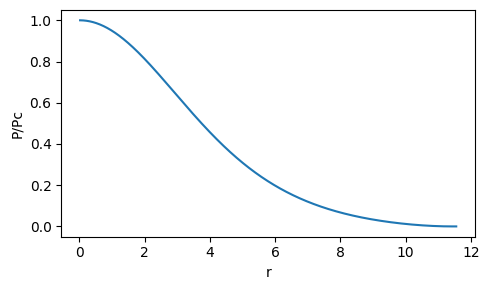

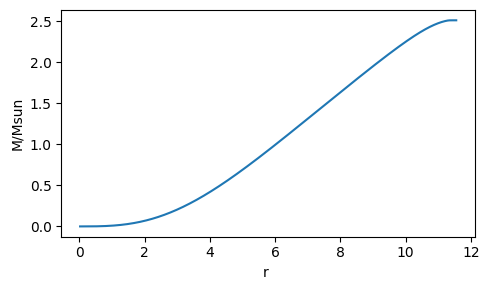

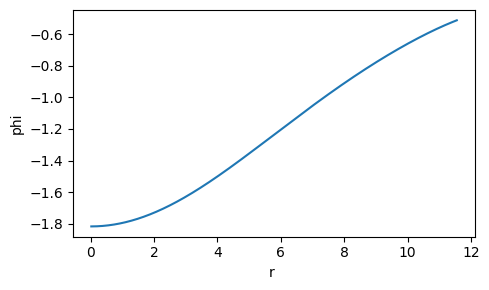

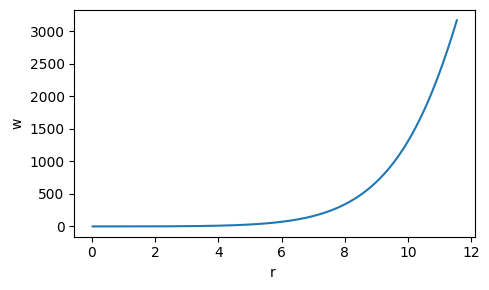

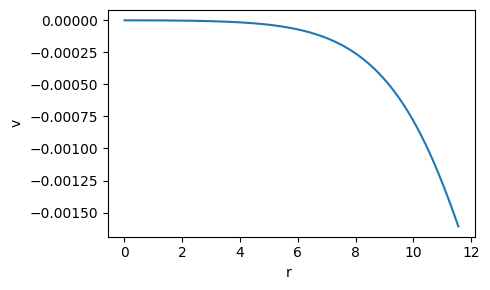

In [12]:
mpl.rcParams['figure.figsize'] = (5, 3)
r_arr = r_arr/km2cm


plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, phi)
plt.xlabel("r ")
plt.ylabel("phi")
plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("w")
plt.show()

plt.figure()
plt.plot(r_arr, v)
plt.xlabel("r ")
plt.ylabel("v")
plt.show()